In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format ='retina'
from datetime import datetime, timedelta
import pandas_datareader.data as web
import missingno as msno
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score,RepeatedKFold,learning_curve
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,mean_absolute_error,confusion_matrix,multilabel_confusion_matrix,plot_confusion_matrix,f1_score,roc_curve
import xgboost as xgb
from sklearn.feature_selection import RFE, RFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

start = datetime(2000,1,1)
#end = datetime(2019,12,31)
end = datetime.today()

#assets = ['^GSPC','^VIX','^VVIX']
assets = ['^GSPC','^VIX','^VVIX','ZN=F','DX=F','ZT=F','EEM']
#assets = ['GC=F','CL=F','^GSPC','^RUT','ZN=F','ZT=F','HG=F','DX=F','^VIX','EEM','EURUSD=X','CNY=X','CHF=X', '^VVIX','JPY=X'],'yahoo',start,end)
df = web.DataReader(assets,'yahoo',start,end)

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def plot_validation_curves(estimator,X,y,search,param_grid,score,cv,n_iter,n_jobs,fix,refit,return_train_score,verbose,error_score):
    if search == 'Grid':
        GS = GridSearchCV(estimator=estimator,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring=score,error_score=error_score,refit=refit,return_train_score=return_train_score,verbose=verbose)
        grid = GS.fit(X, y)    
    if search == 'Randomized':
        RS = RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,n_jobs=n_jobs,n_iter=n_iter,cv=cv, scoring=score,error_score=error_score,refit=refit,return_train_score=return_train_score,verbose=verbose)
        grid = RS.fit(X,y)
    ncols=2
    nrows= np.ceil((len(param_grid))/ncols).astype('int')
    fig,ax = plt.subplots(figsize=(16,nrows*4))
    for i, param in enumerate(param_grid):
        plt.subplot(nrows,ncols,i+1)
        sns.lineplot(x='param_'+str(param),y='mean_test_score',data=grid.cv_results_,label='Test')
        sns.lineplot(x='param_'+str(param),y='mean_train_score',data=grid.cv_results_,label='Train')
        plt.scatter(grid.best_params_[str(param)], grid.best_score_,marker='*',s=200,c='k', label=str(grid.best_score_.round(4)))
        plt.legend()
    fig.suptitle(str(search)+' Search - Best Score: %f using %s' % (grid.best_score_, grid.best_params_),fontsize=14,y=1,weight='bold')
    plt.tight_layout(pad=2)
    
    if fix == True:
        fig,ax = plt.subplots(figsize=(16,nrows*4))
        for idx, i in enumerate([k for k,v in param_grid.items() if len(v)>1]):
            plt.subplot(nrows,ncols,idx+1)
            best_update = {}
            best_copy = grid.best_params_.copy()
            best_update = {key: (param_grid[i] if (key==i) else [best_copy[key]]) for key in best_copy}
            #print(best_update)
            result = GridSearchCV(estimator=estimator,param_grid=best_update,n_jobs=n_jobs, cv=cv, scoring=score,error_score=0,refit=False,return_train_score=True,verbose=verbose)
            result_fix = result.fit(X,y)
            print("Varying %s Best Score: %f using %s" % (i, result_fix.best_score_, result_fix.best_params_))
            sns.lineplot(x='param_'+str(i),y='mean_test_score',data=result_fix.cv_results_,label='Test score varying '+str(i))
            sns.lineplot(x='param_'+str(i),y='mean_train_score',data=result_fix.cv_results_,label='Train score varying '+str(i))
            plt.scatter(x=result_fix.best_params_[str(i)], y=result_fix.best_score_, marker = '*', s = 200, c='k',label="Best Score: %f" % (result_fix.best_score_.round(4)))
            plt.legend()
        fig.suptitle("RandomizedSearchCV varying %s in turn with best_params_ of %s" % (i, result_fix.best_params_),fontsize=14,y=1,weight='bold')
        plt.tight_layout(pad=2)
    return grid.best_estimator_, grid.best_score_, grid.best_params_

In [3]:
from sklearn.exceptions import NotFittedError

def train_test_r2(estimators,X_train,y_train,X_test,y_test,index=None):
    train_scores = []
    test_scores = []
    
    for est in estimators:
        try:
            r2_train = r2_score(y_train, est.predict(X_train))   
        except NotFittedError:
            param_empty= {}
            cv=5
            gs = GridSearchCV(estimator=est,param_grid=param_empty,n_jobs=4,cv=cv,scoring='neg_root_mean_squared_error',
                              error_score=0,refit=True,return_train_score=False,verbose=0)
            gs.fit(X_train,y_train)
            r2_train = r2_score(y_train, gs.predict(X_train))
            train_scores.append(r2_train)
            r2_test = r2_score(y_test, gs.predict(X_test))
            test_scores.append(r2_test)
        else:
            train_scores.append(r2_train)
            r2_test = r2_score(y_test, est.predict(X_test))
            test_scores.append(r2_test)
    table = pd.DataFrame(data=zip(train_scores,test_scores), columns=['train','test'],index=index)
    return table

In [4]:
df_open = df['Open'].rename(columns={'^GSPC':'^GSPC_open'})
df_close = df['Close'].rename(columns={'^GSPC':'^GSPC'})
df_high = df['High'].rename(columns={'^GSPC':'^GSPC_high'})
df_low = df['Low'].rename(columns={'^GSPC':'^GSPC_low'})

In [5]:
df_ = df_close.merge(df_open['^GSPC_open'],on='Date').merge(df_high['^GSPC_high'],on='Date').merge(df_low['^GSPC_low'],on='Date')

In [6]:
#intraday high low range
df_['^GSPC_high_low_pct'] = (df_['^GSPC_high'] - df_['^GSPC_low'])/df_['^GSPC']
df_ = df_.drop(['^GSPC_open','^GSPC_high','^GSPC_low'],axis=1)

In [7]:
df_.isnull().sum()

^GSPC                   32
^VIX                    32
^VVIX                 1795
ZN=F                   258
DX=F                   161
ZT=F                   193
EEM                    854
^GSPC_high_low_pct      32
dtype: int64

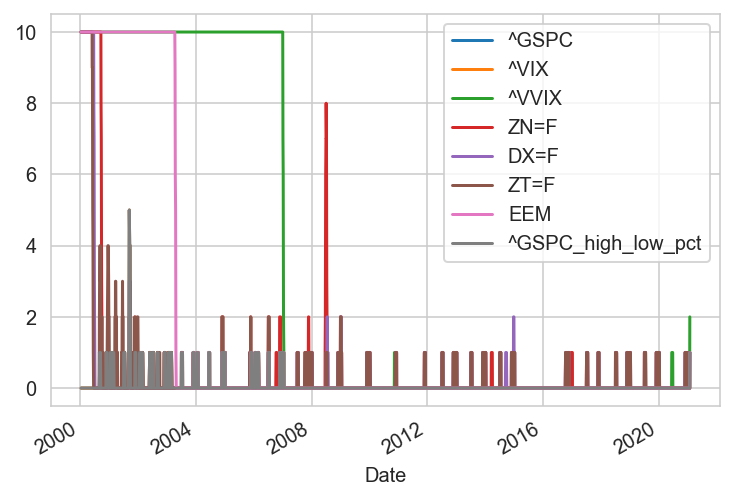

In [8]:
#inspecting length of NaN gaps
df_.isnull().rolling(10,axis=0).sum().plot()

In [9]:
#fill NaN gaps in data
df_ = df_.fillna(method='ffill',inplace=False,limit=3)
df_.isnull().sum()

^GSPC                    1
^VIX                     1
^VVIX                 1790
ZN=F                   187
DX=F                   119
ZT=F                   105
EEM                    841
^GSPC_high_low_pct       1
dtype: int64

In [10]:
#apply median imputation for missing start values for appropriate assets (i.e. without a strong trend)
imputer = SimpleImputer(strategy='median')
impute_cols = ['^VVIX','EEM']
imputed=imputer.fit_transform(df_.loc[:,impute_cols].values)
df_imputed = pd.DataFrame(data=imputed,index=df_.index,columns=[impute_cols])
df_[impute_cols] = df_imputed

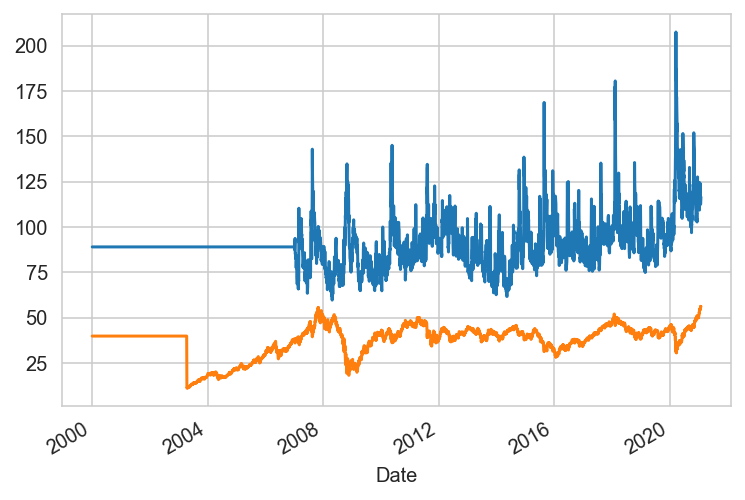

In [11]:
df_['^VVIX'].plot()
df_['EEM'].plot()
plt.show()

In [12]:
#FEATURE ENGINEERING FUNCTION

def add_features(df,target_asset,periods):
    df_add_features = df
    print(df_add_features.shape)
    
    #intraday high-low range of spot
    h_l_pct = target_asset+'_high_low_pct'
    data = pd.DataFrame()
    for i in periods:
        data = df_add_features[h_l_pct].rolling(i).mean()
        df_add_features = pd.concat([df_add_features,data.rename(target_asset+' '+str(i)+'d avg intraday rng')],axis=1)
    print(df_add_features.shape)

    vol_cols = df_add_features.columns
    #annualised volatility for features and target_col
    data = pd.DataFrame()
    for i in periods:
        data = df_add_features.loc[:,vol_cols].pct_change().rolling(i).std().add_suffix(' '+str(i)+'d vol') * (252**0.5) * 100
        df_add_features = pd.concat([df_add_features,data],axis=1)
    print(df_add_features.shape)

    #pct_change for features
    data = pd.DataFrame()
    for i in periods:
        data = df_add_features.loc[:,vol_cols].pct_change(periods=i).add_suffix(' '+str(i)+'d % chg')
        df_add_features = pd.concat([df_add_features,data],axis=1)
    print(df_add_features.shape)

    target_col = target_asset+' '+str(periods[0])+'d vol'
    
    #target_col pct from mean
    data = pd.DataFrame()
    for i in periods:
        data = df_add_features[target_col]/df_add_features[target_col].rolling(i).mean(skipna=True)-1
        df_add_features = pd.concat([df_add_features,data.rename('Target % from '+str(i)+'d Mean')],axis=1)
    print(df_add_features.shape)

    #feature pct from mean
    data = pd.DataFrame()
    for i in periods:
        data = (df_add_features.loc[:,vol_cols]/df_add_features.loc[:,vol_cols].rolling(i).mean(skipna=True) - 1).add_suffix(' % from '+str(i)+'d Mean')
        df_add_features = pd.concat([df_add_features,data],axis=1)
    print(df_add_features.shape)
    
    return df_add_features, vol_cols, target_col

In [13]:
target_asset='^GSPC'
#two periods
periods=[5,20]
df_with_features, vol_cols, target_col = add_features(df=df_,target_asset=target_asset,periods=periods)

(5331, 8)
(5331, 10)
(5331, 30)
(5331, 50)
(5331, 52)
(5331, 72)


In [14]:
#Creating df used for live predictions (later)
df_with_features_latest = df_with_features.iloc[-1]

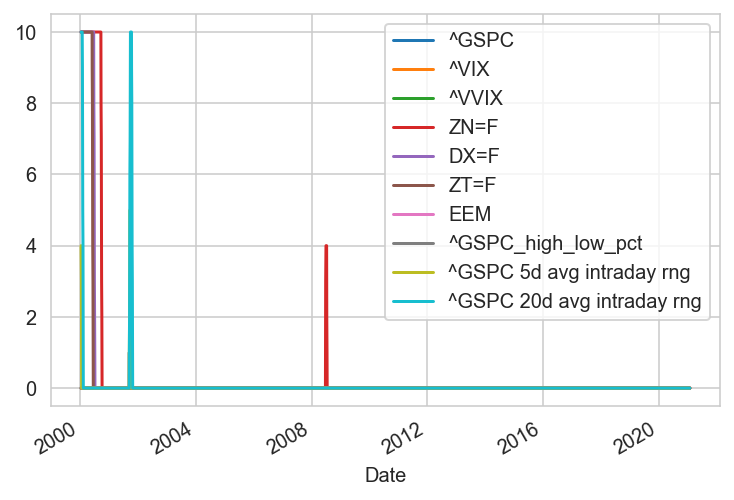

In [15]:
df_with_features[vol_cols].isnull().rolling(10,axis=0).sum().plot()

In [16]:
#creating actual target on which to train/predict

df_with_features['target'] = df_with_features[target_col].shift(-periods[0])
df_with_features.shape

(5331, 73)

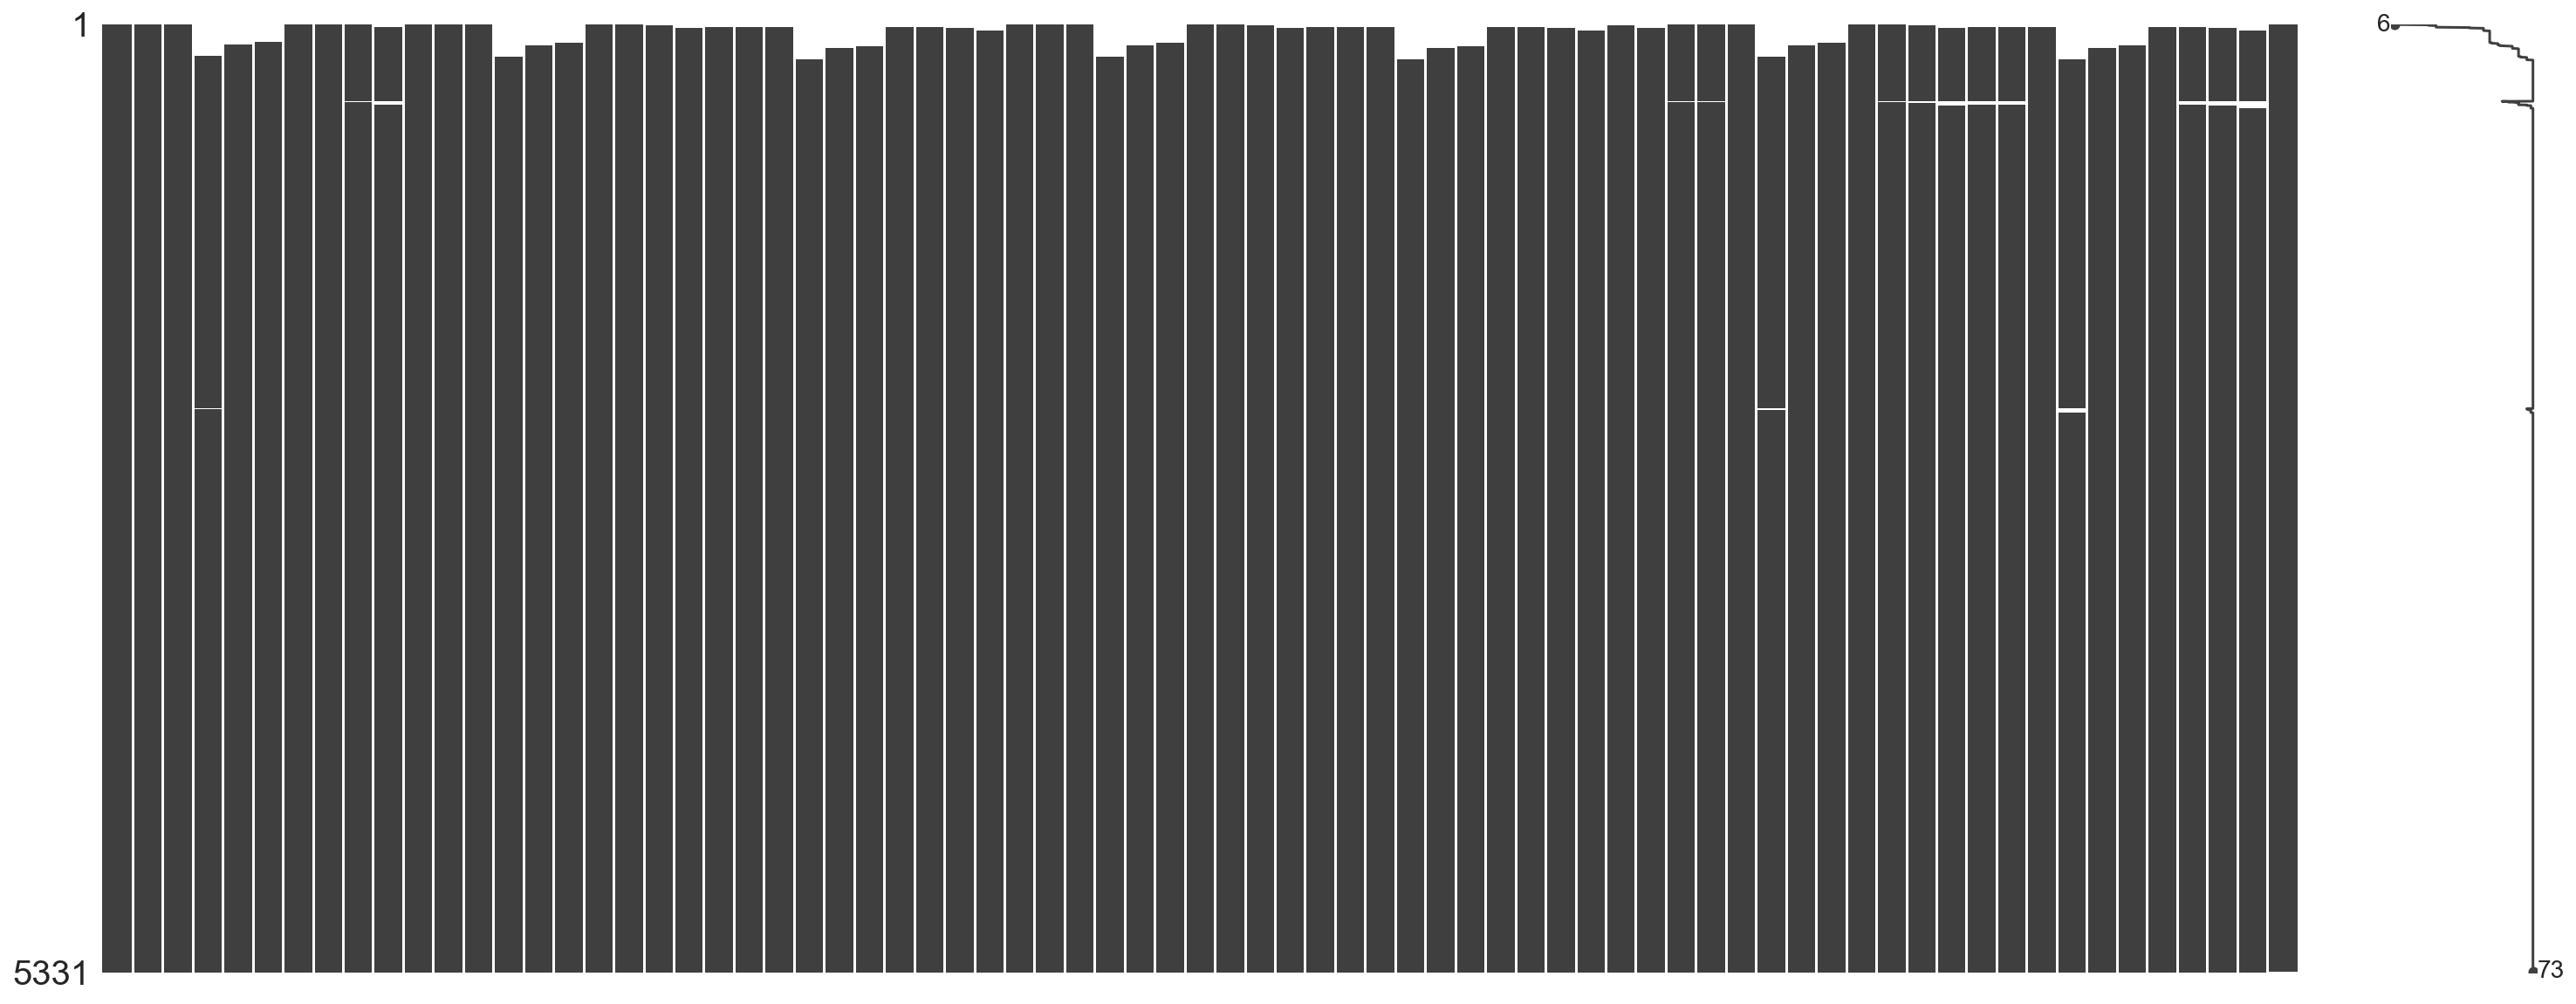

In [17]:
msno.matrix(df_with_features)

In [18]:
#remove rows where starting/ending values are missing due to rolling calcs and gaps in data
df_clean = df_with_features.dropna(axis=0,inplace=False)
df_clean.shape

(5061, 73)

In [19]:
#correl ranking
corr = df_clean.corr()
print(corr['target'].sort_values(ascending=False))

target                        1.000000
^VIX                          0.769959
^GSPC 5d avg intraday rng     0.767738
^GSPC 20d avg intraday rng    0.705048
^GSPC 20d vol                 0.702021
                                ...   
EEM % from 20d Mean          -0.282463
^GSPC 5d % chg               -0.294533
EEM 20d % chg                -0.296695
^GSPC % from 20d Mean        -0.489173
^GSPC 20d % chg              -0.490341
Name: target, Length: 73, dtype: float64


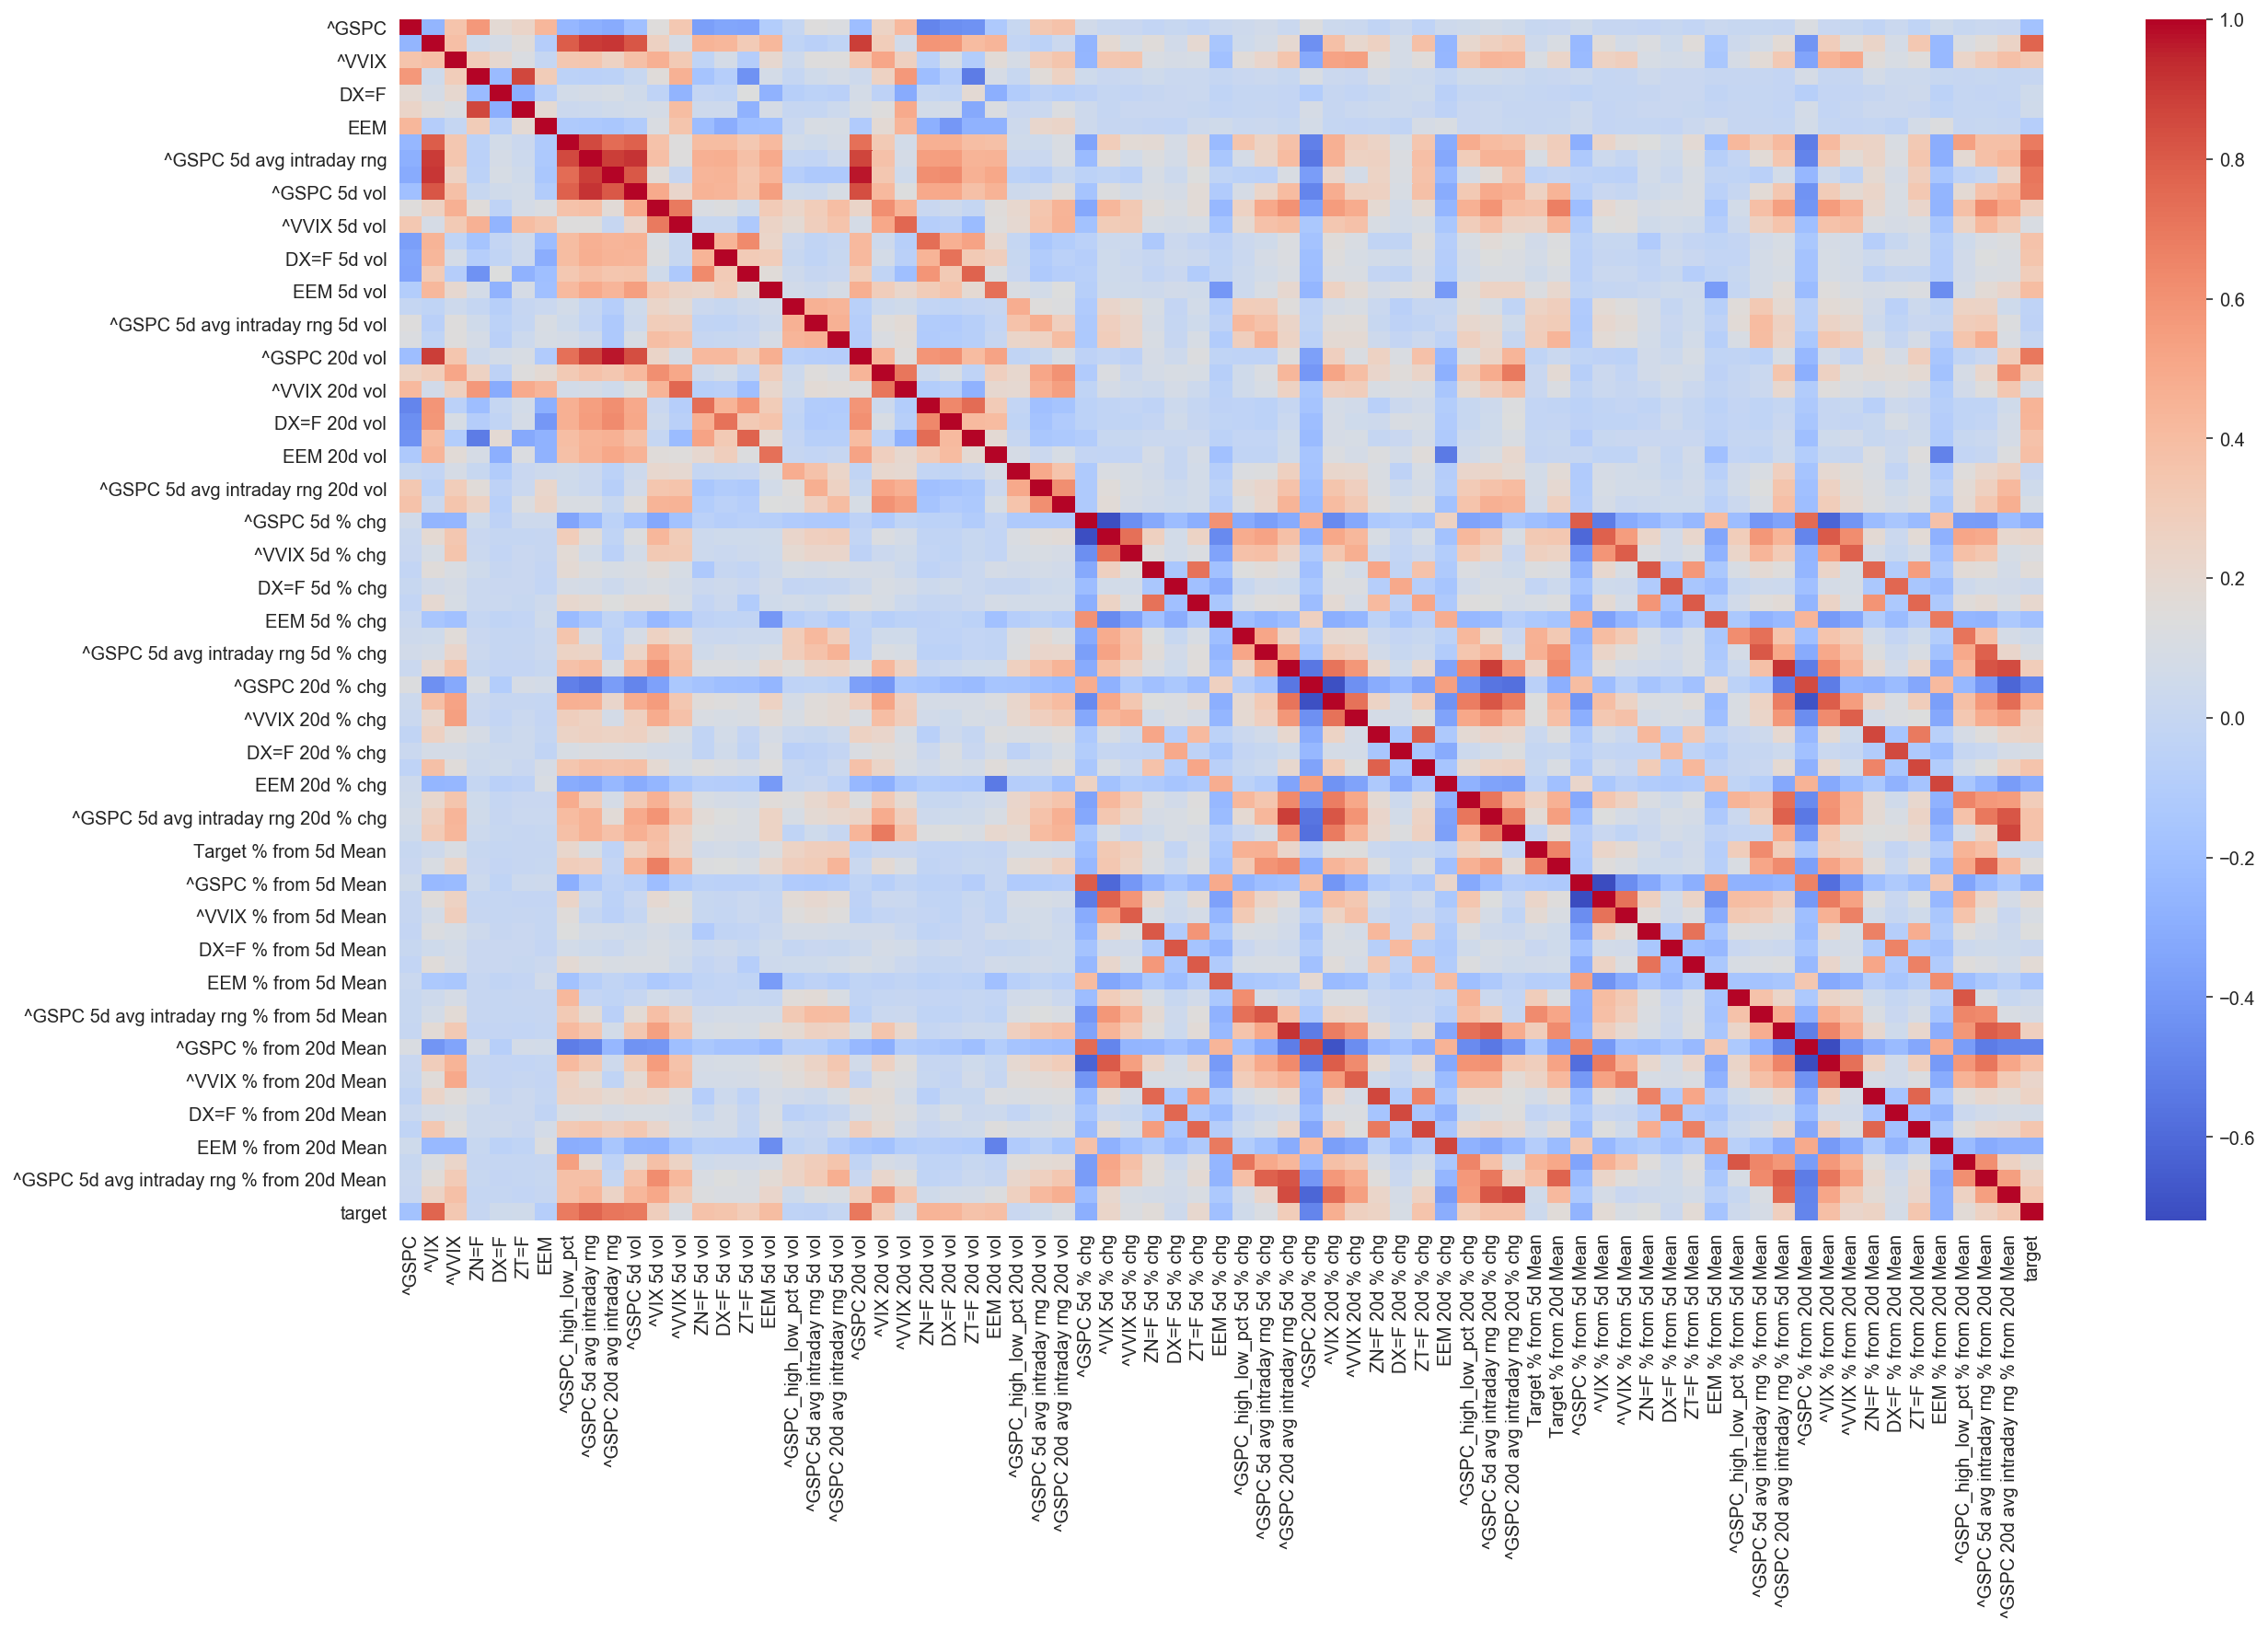

In [20]:
#correl matrix
plt.subplots(figsize=(20,12))
sns.heatmap(corr,annot=False,cmap='coolwarm')

In [21]:
#creating binary higher/lower target for classification analysis
df_clean.loc[:,'target_binary'] = np.where(df_clean.loc[:,'target']>df_clean.loc[:,target_col],1,-1)

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [22]:
#check classification target is not unbalanced
df_clean['target_binary'].value_counts()

-1    2553
 1    2508
Name: target_binary, dtype: int64

In [23]:
df_clean[['^GSPC',target_col,'target','target_binary']].corr()

,^GSPC,^GSPC 5d vol,target,target_binary
^GSPC,1.000000,-0.189362,-0.176697,-0.018883
^GSPC 5d vol,-0.189362,1.000000,0.696783,-0.258208
target,-0.176697,0.696783,1.000000,0.257684
target_binary,-0.018883,-0.258208,0.257684,1.000000


In [24]:
#create features and target dataframes
df_clean_features = df_clean.drop(['target','target_binary'],axis=1)
df_clean_target = df_clean['target']
print(len(df_clean.columns),' >> ',len(df_clean_features.columns))

74  >>  72


In [25]:
#train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_clean_features,df_clean_target,test_size=0.2,shuffle=True)

In [26]:
#problem with PowerTransformer/negative/values/yeo-johnson so apply StandardScaler first w/o standardisation
pt_X = make_pipeline(StandardScaler(with_std=False),PowerTransformer(standardize=True))
X_train_scaled = pt_X.fit_transform(X_train)
X_test_scaled = pt_X.transform(X_test)

pt_y = make_pipeline(StandardScaler(with_std=False),PowerTransformer(standardize=True))
y_train_scaled = pt_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = pt_y.transform(y_test.values.reshape(-1,1))

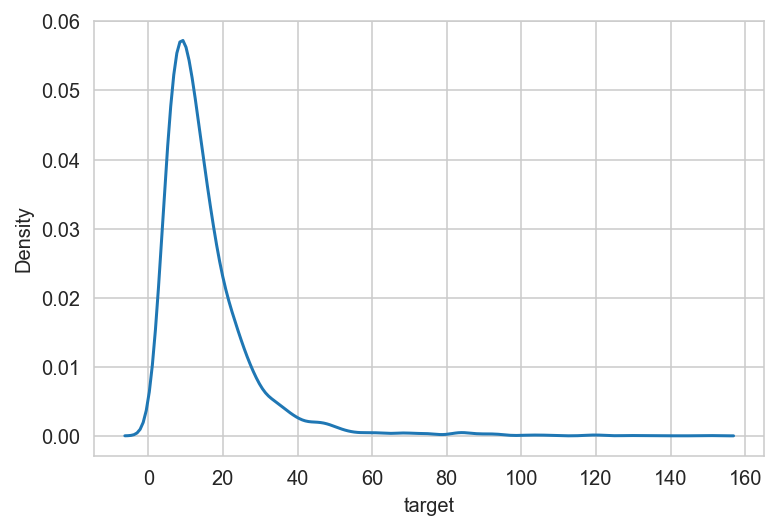

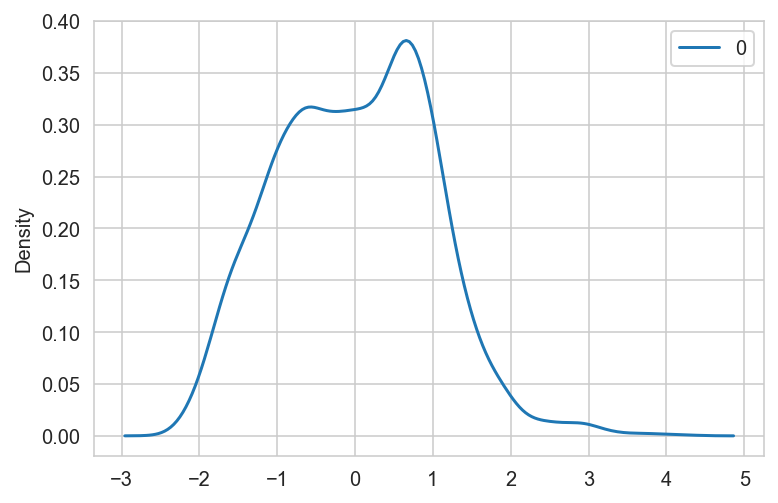

In [27]:
sns.kdeplot(data=y_train)
plt.show()
sns.kdeplot(data=y_train_scaled)
plt.show()

Varying gamma Best Score: -0.443759 using {'colsample_bytree': 0.4000000000000001, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.5, 'n_estimators': 50}
Varying min_child_weight Best Score: -0.444879 using {'colsample_bytree': 0.4000000000000001, 'gamma': 0.5000000000000001, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.3, 'n_estimators': 50}
Varying colsample_bytree Best Score: -0.444879 using {'colsample_bytree': 0.4000000000000001, 'gamma': 0.5000000000000001, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.5, 'n_estimators': 50}
Varying learning_rate Best Score: -0.444879 using {'colsample_bytree': 0.4000000000000001, 'gamma': 0.5000000000000001, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.5, 'n_estimators': 50}
Varying max_depth Best Score: -0.444879 using {'colsample_bytree': 0.4000000000000001, 'gamma': 0.5000000000000001, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.5, 'n_estimators': 50}
Varyin

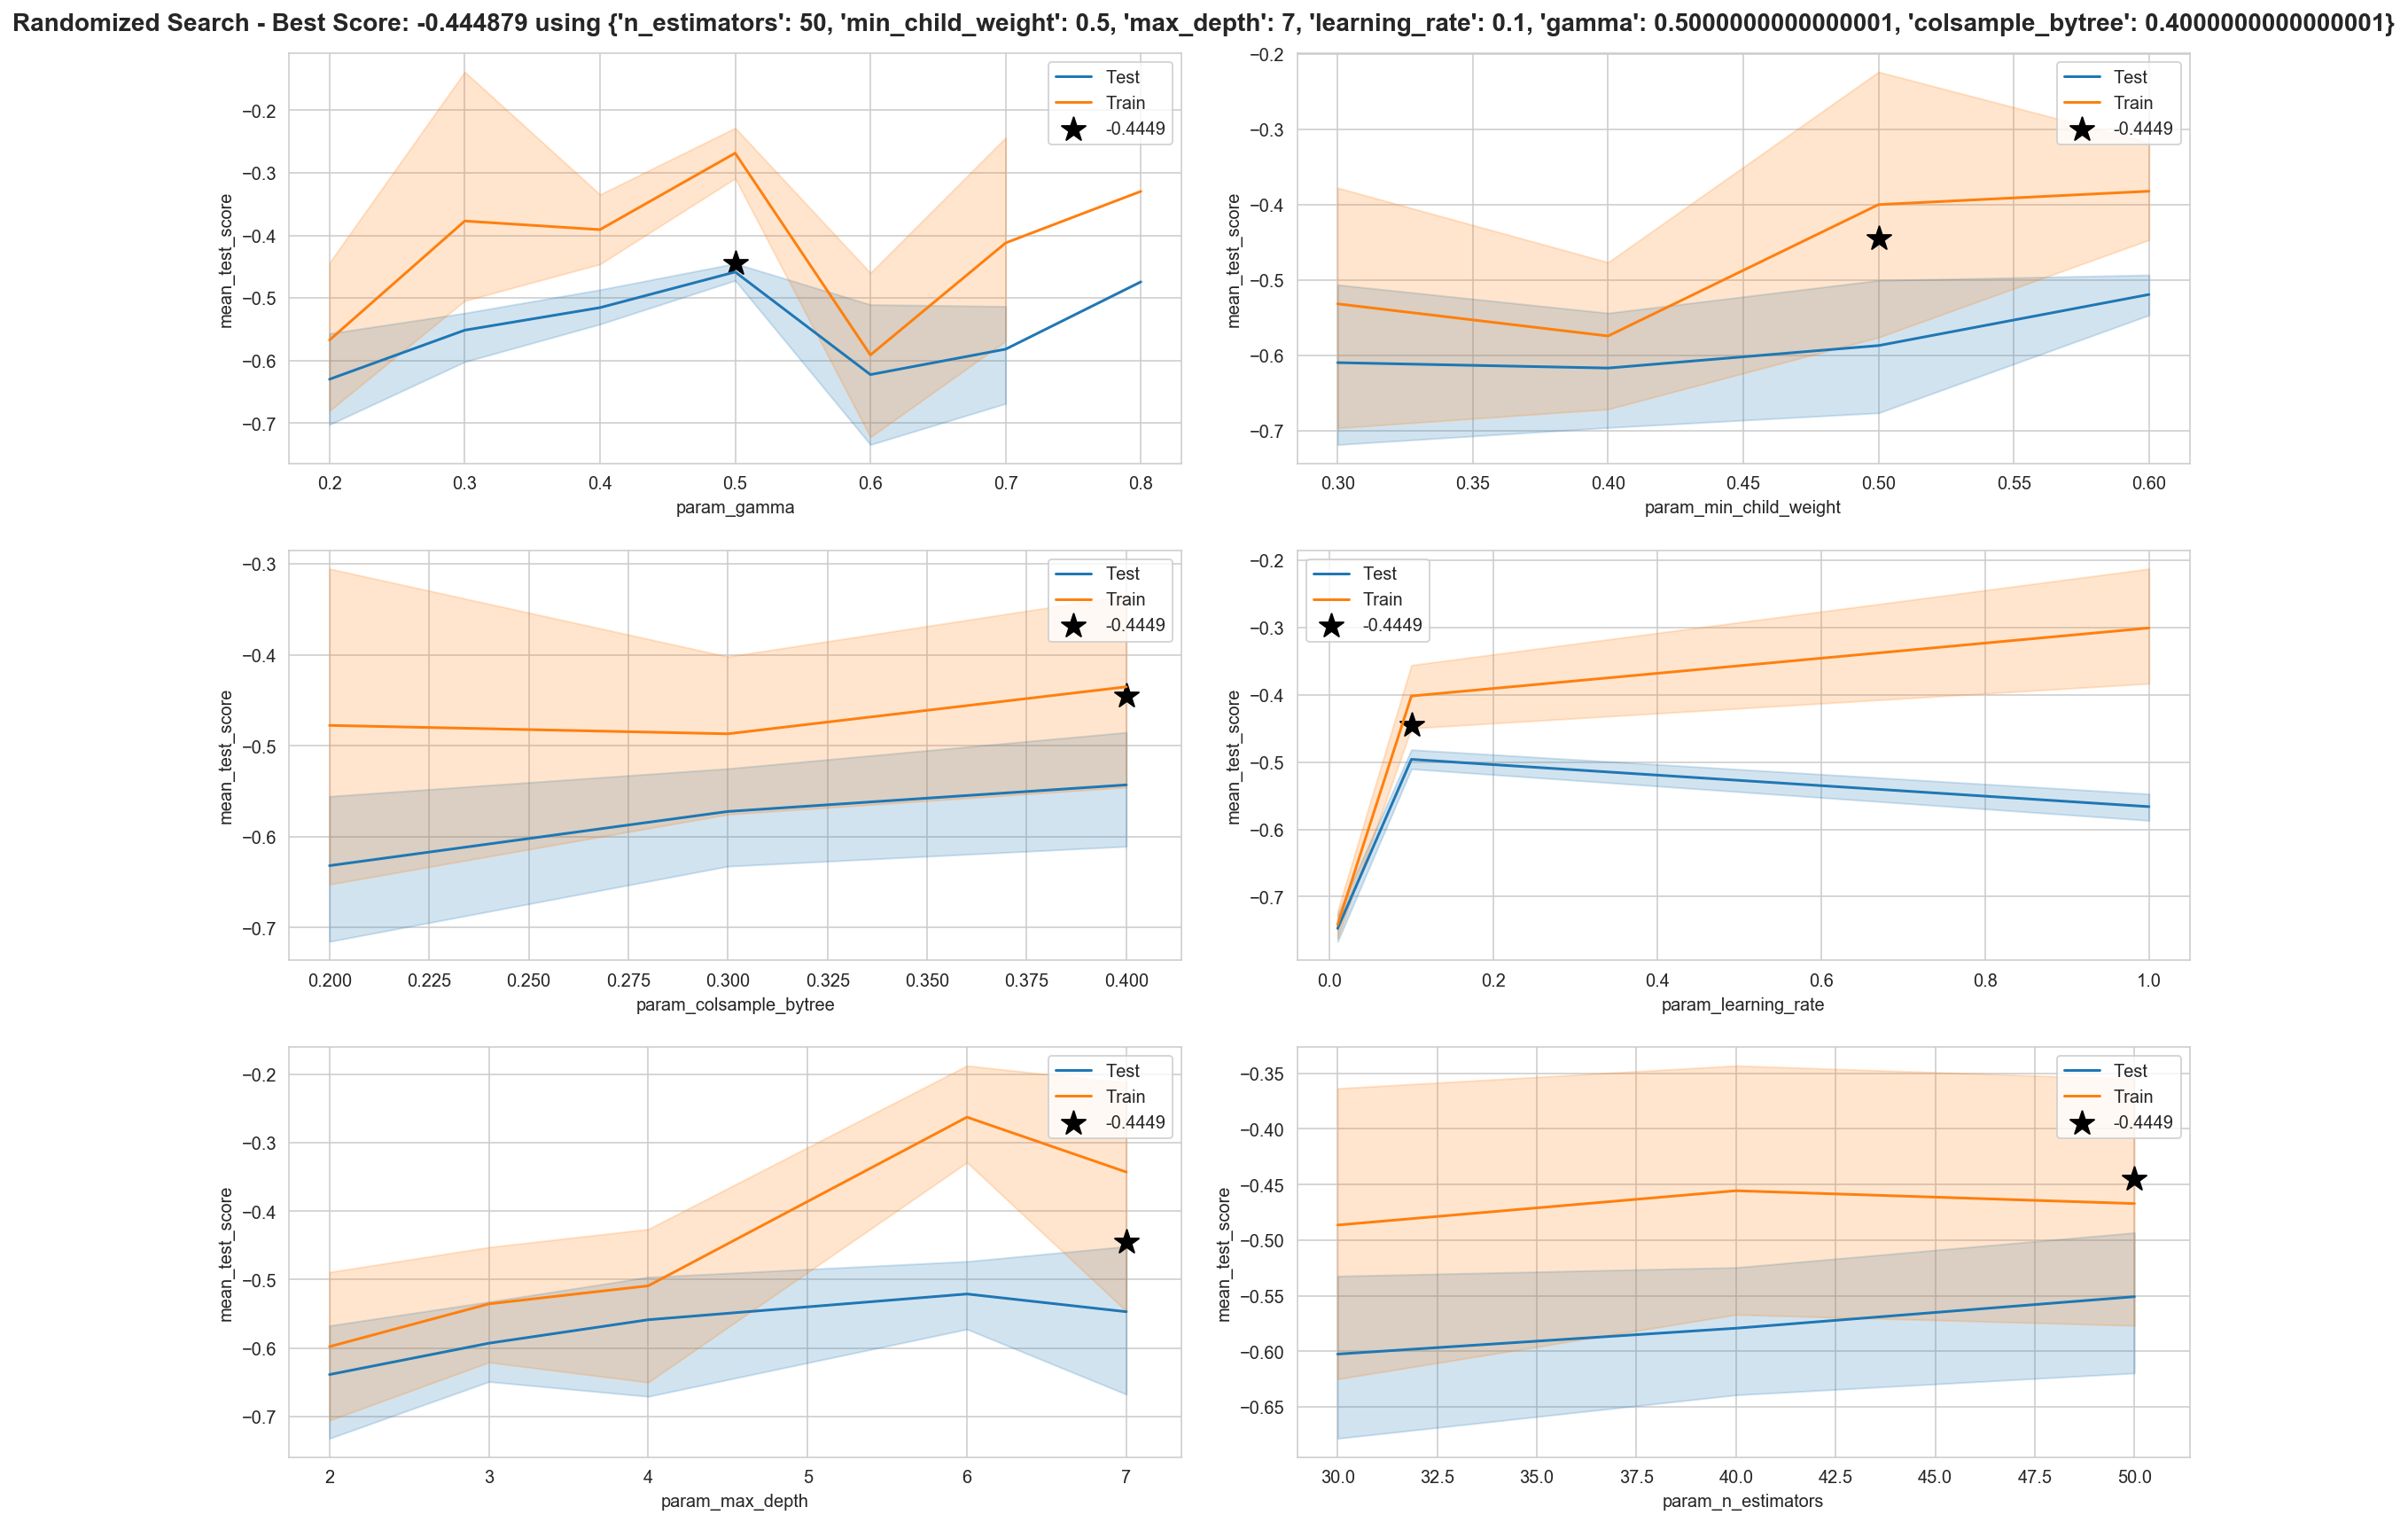

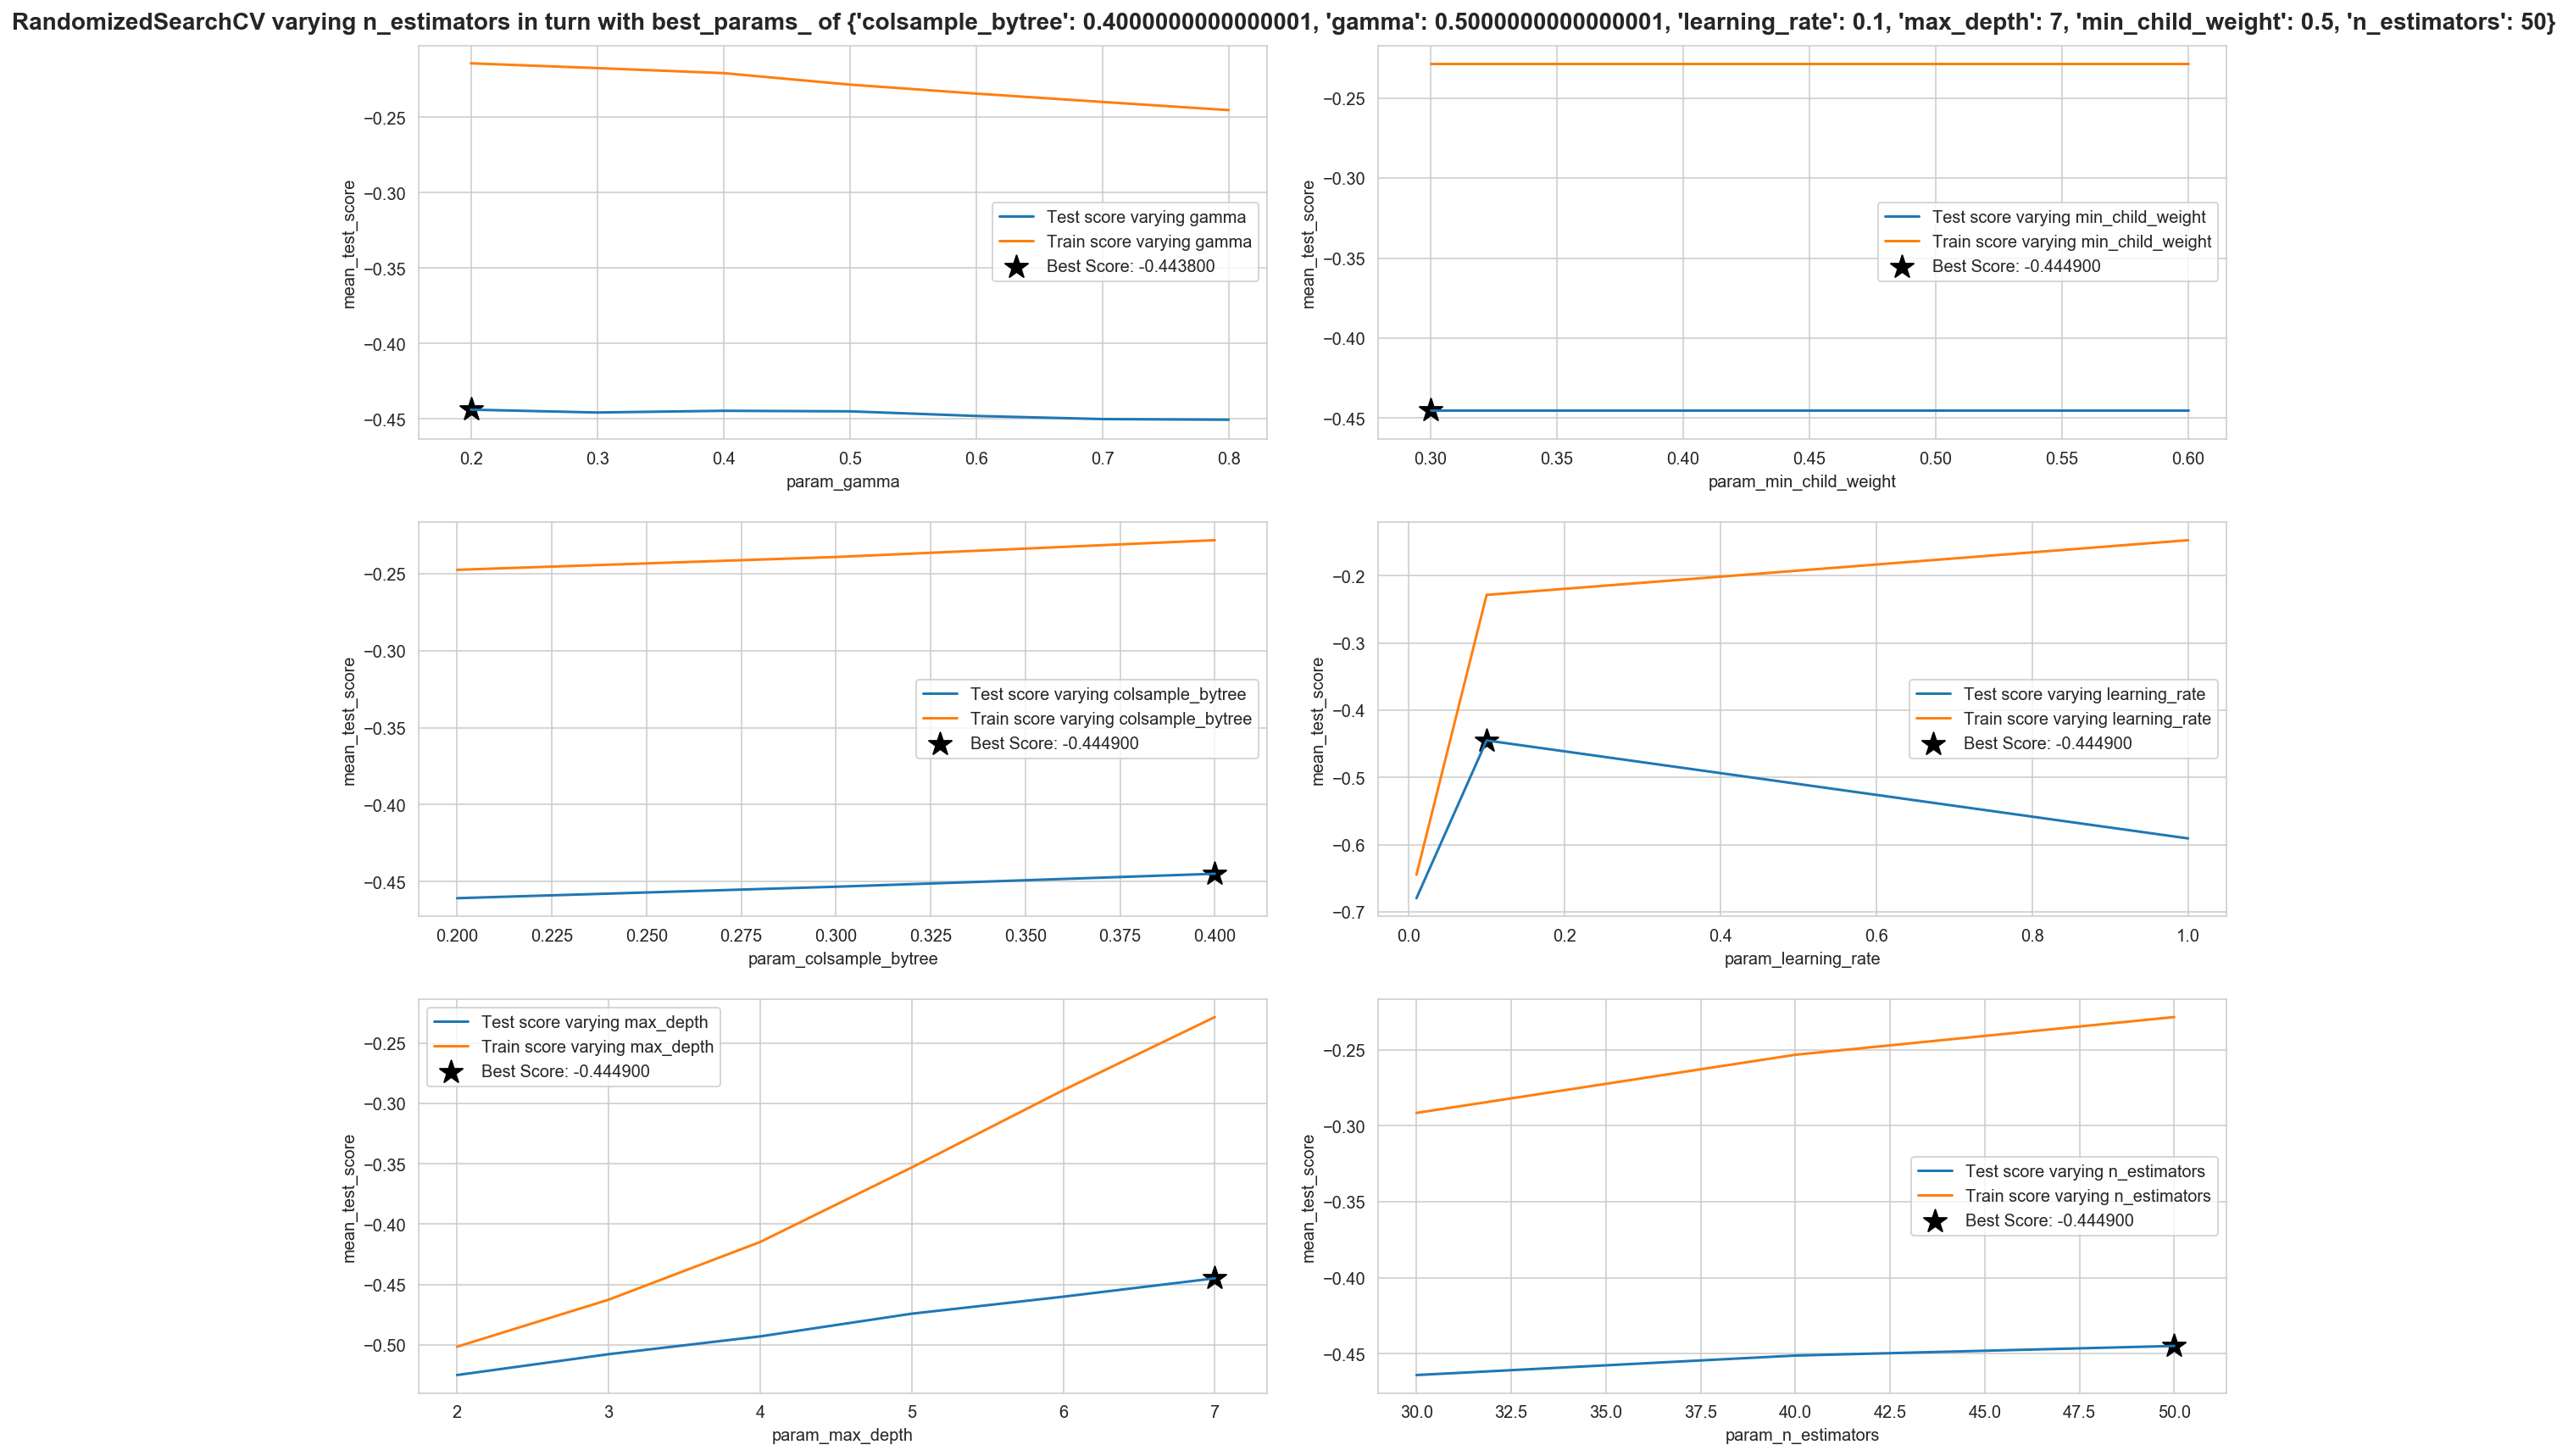

In [28]:
#XGB Model and Hypertuning
param_grid_xgb = {
    'gamma': np.arange(0.2,0.8,0.1),
    'min_child_weight':np.arange(0.3,0.7,0.1),
    'colsample_bytree': np.arange(0.2,0.5,0.1),
    'learning_rate': [0.01, 0.1,1],
    'max_depth': np.arange(2, 8, 1),
    'n_estimators': np.arange(30, 60, 10)
                    }

xgb_opt = plot_validation_curves(xgb.XGBRegressor(),
                       X=X_train_scaled,y=y_train_scaled,
                       search='Randomized',
                       param_grid=param_grid_xgb,
                       score='neg_mean_absolute_error',
                       cv=5,n_iter=30,n_jobs=4,verbose=False,error_score=0,refit=True,return_train_score=True,
                       fix=True)

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Varying min_samples_split Best Score: -0.571290 using {'criterion': 'mae', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 60}
Varying n_estimators Best Score: -0.569873 using {'criterion': 'mae', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 50}


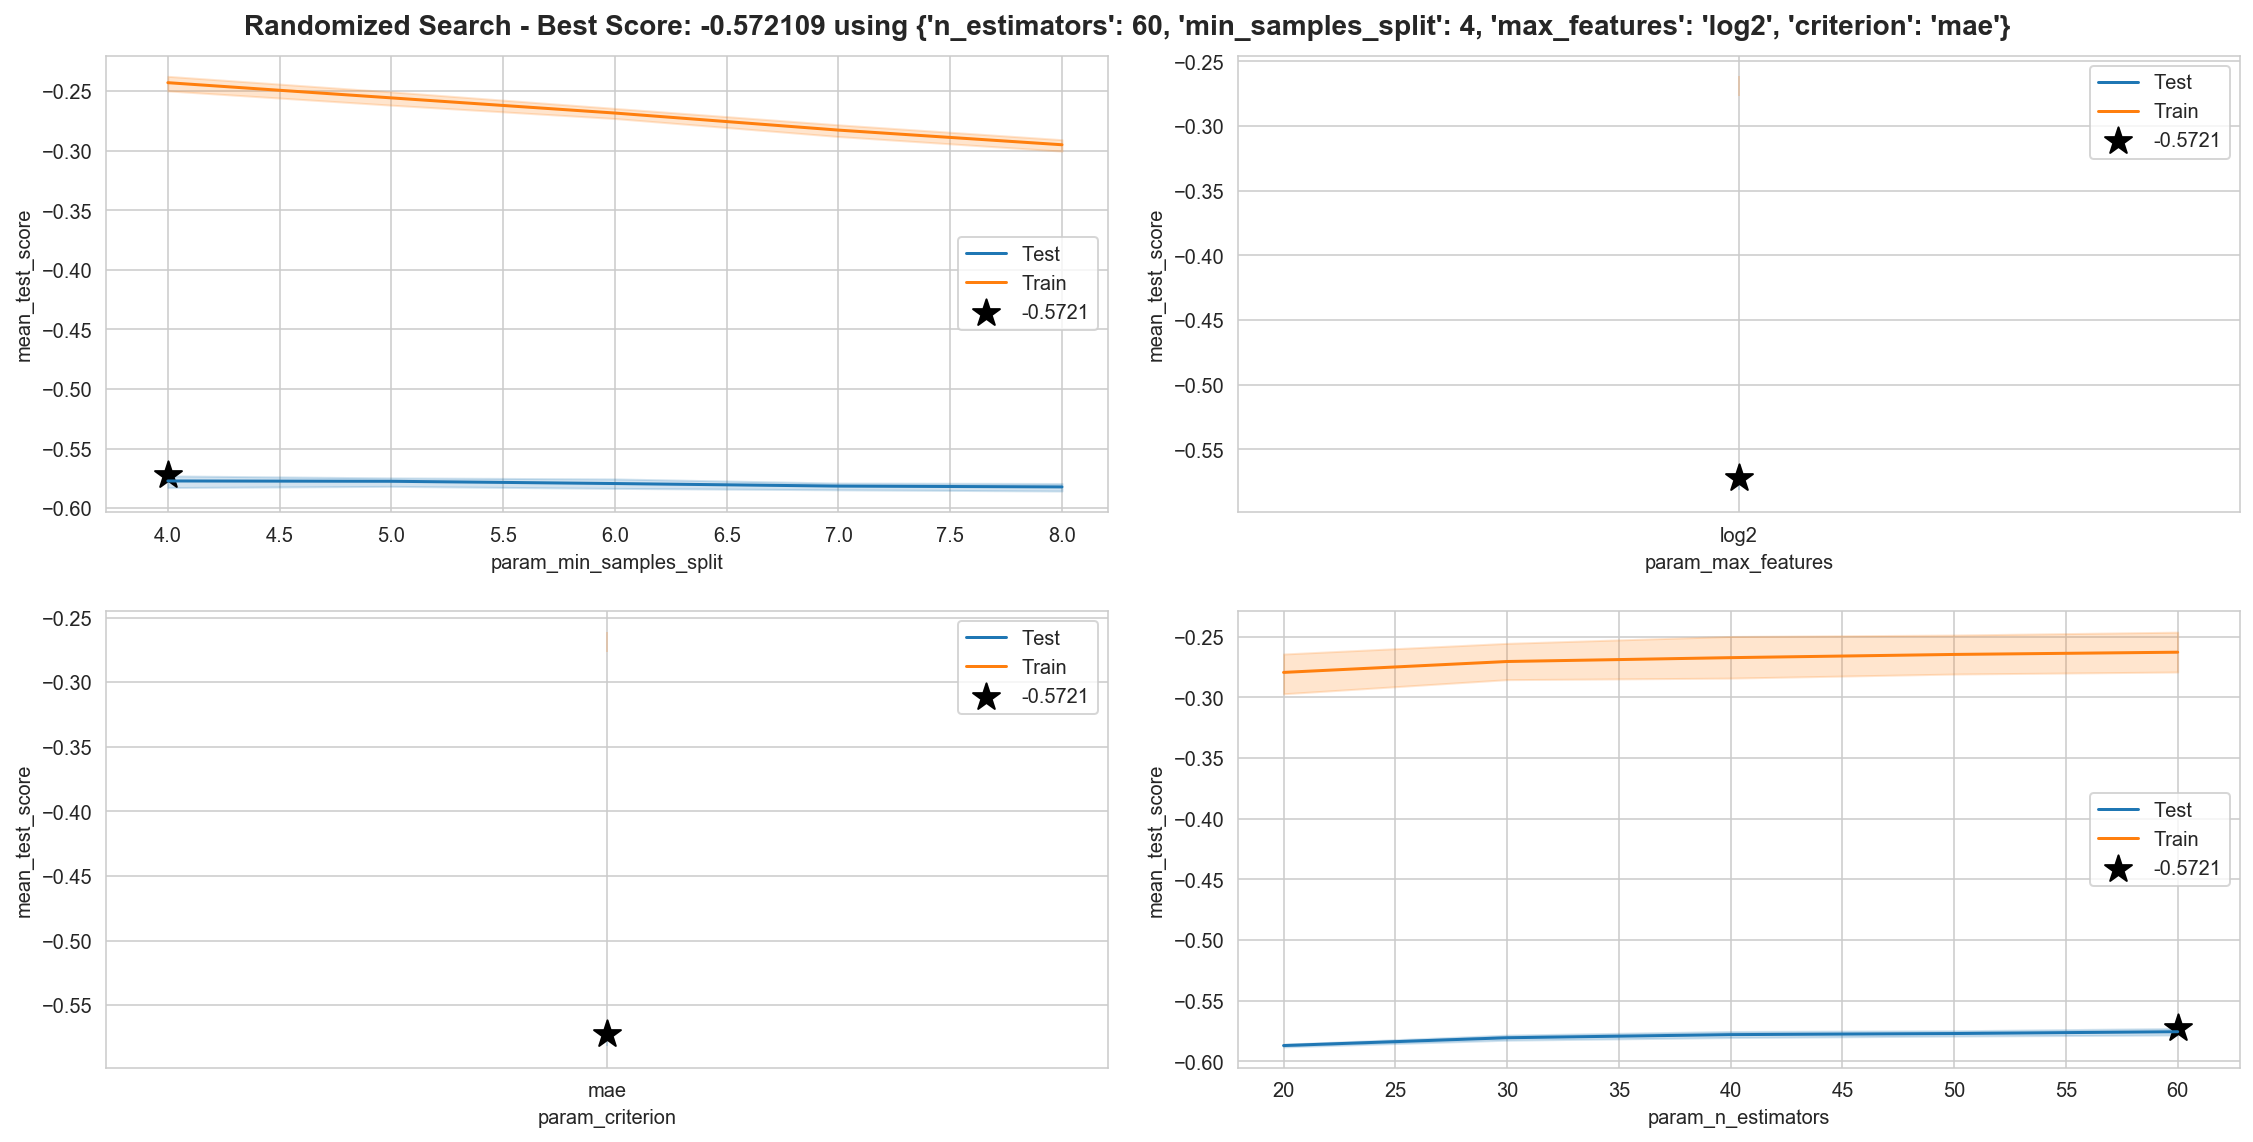

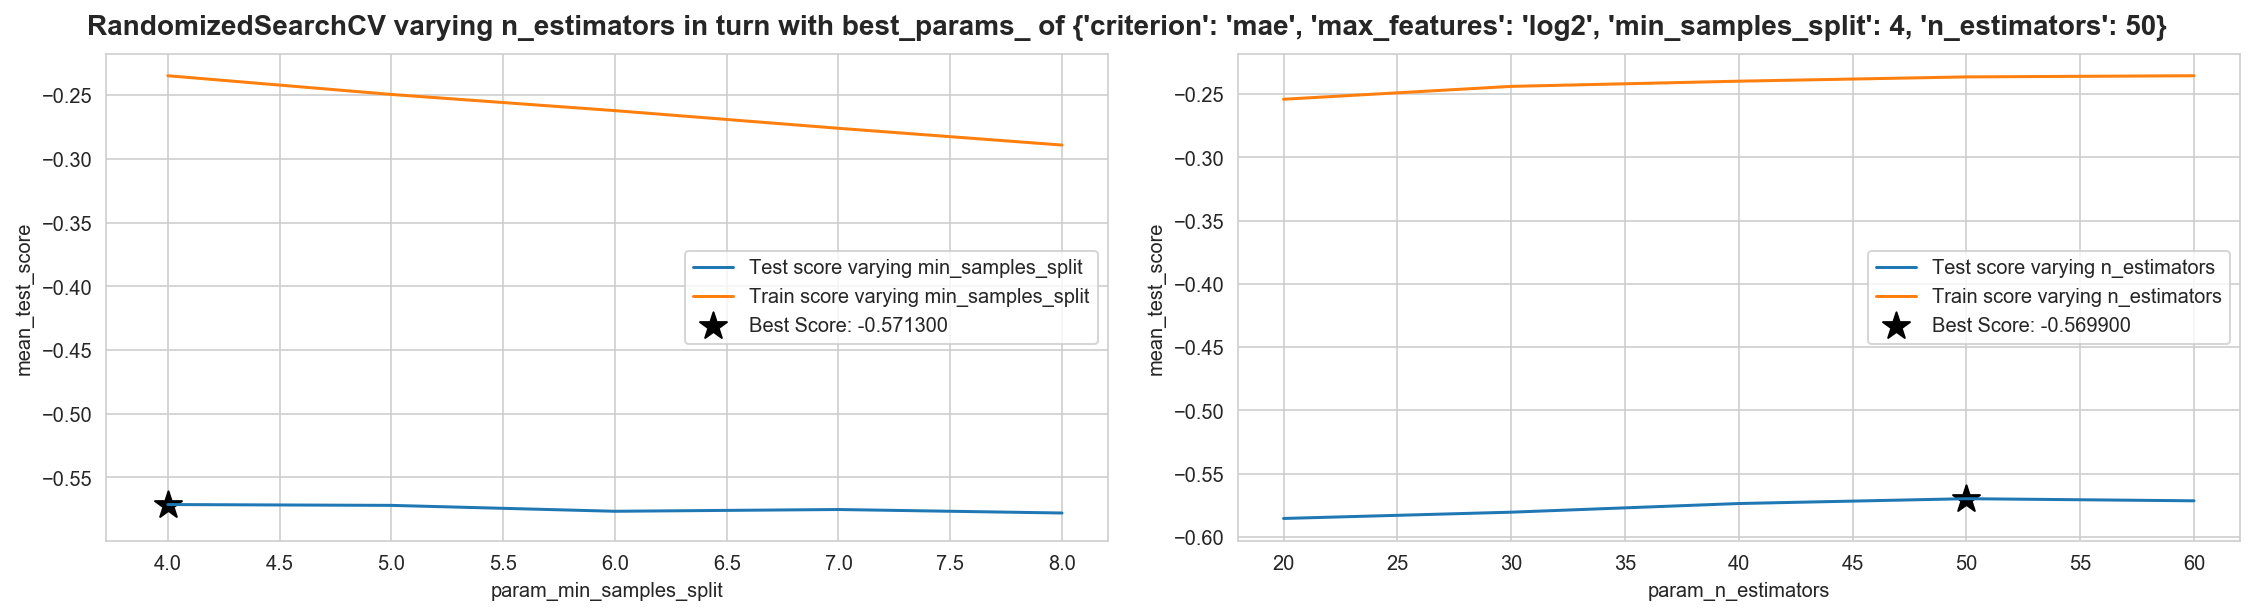

In [29]:
#RF Model and Hypertuning
param_grid_rf = {
        'min_samples_split':np.arange(4,9,1),
        'max_features':['log2'],
        'criterion':['mae'],
        'n_estimators':np.arange(20,70,10)
                    }

rf_opt = plot_validation_curves(RandomForestRegressor(),
                       X=X_train_scaled,y=np.ravel(y_train_scaled),
                       search='Randomized',
                       param_grid=param_grid_rf,
                       score='neg_root_mean_squared_error',
                       cv=5,n_iter=30,n_jobs=4,verbose=False,refit=True,return_train_score=True,error_score=0,
                       fix=True)

In [30]:
#Learning curve to inspect training/test size and quality of fit
def learning_curves(estimator, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, train_sizes=train_sizes,cv=cv, scoring='neg_root_mean_squared_error',n_jobs=4)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    validation_scores_mean = np.mean(validation_scores,axis=1)
    validation_scores_std = np.std(validation_scores,axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training neg RMSE',color='r')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation neg RMSE',color='g')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,color="g")
    plt.ylabel('neg RMSE', fontsize = 10)
    plt.xlabel('Training set size', fontsize = 10)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 11)
    plt.legend()

In [31]:
#creating labelled list of hyper-tuned models from "plot_validation_curves" with best_estimator_, best_score_, best_params_, unpacked
opt_models = []
opt_models.append(('xgb_opt',*xgb_opt))
opt_models.append(('rf_opt',*rf_opt))

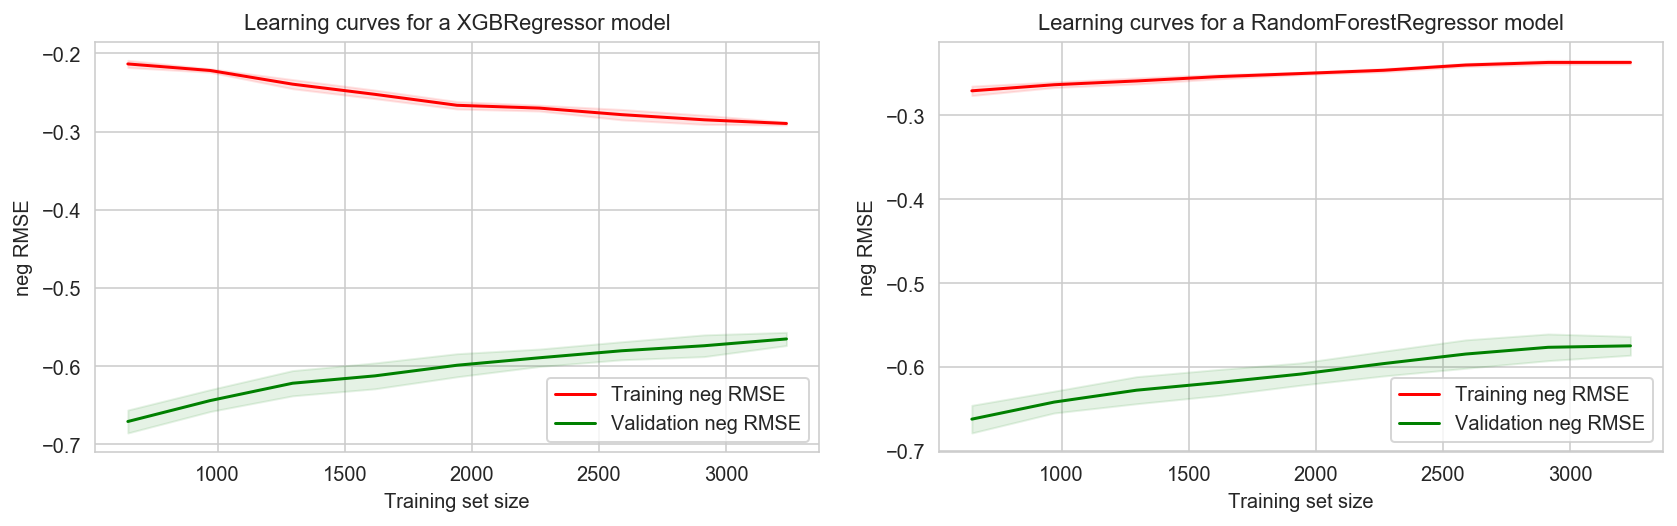

In [32]:
#Plotting learning curves
opt_estimators = [x[1] for x in opt_models]
train_sizes=np.linspace(0.2,1,9)
ncols=2
nrows=np.ceil((len(opt_estimators))/ncols).astype('int')
fig,axes = plt.subplots(nrows,ncols,figsize=(12,4*nrows))
for i, model in enumerate(opt_estimators):
    ax = plt.subplot(nrows,ncols,i+1)
    learning_curves(model, X_train_scaled, y_train_scaled, train_sizes, 5)
fig.tight_layout(pad=2)

xgb_opt: -0.564577 (0.018506)
rf_opt: -0.572270 (0.011617)
Mean: -0.5722696650911623


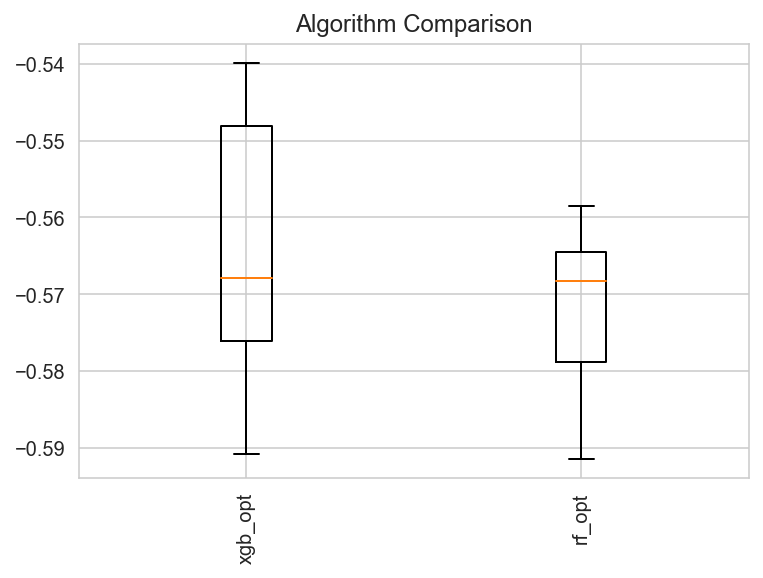

In [33]:
#cross_val_score RMSE on scaled training data
results = []
names = []
for name,model,score,params in opt_models:
    rkfold = RepeatedKFold(n_splits=5, n_repeats=1)
    cv_results = cross_val_score(model, X_train_scaled, np.ravel(y_train_scaled), cv=rkfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))    
    
print('Mean:',np.mean(cv_results.mean()))
plt.boxplot(results, labels=names)
plt.xticks(rotation=90)
plt.title('Algorithm Comparison')
plt.show()

xgb_opt: -0.638727 (0.037716)
rf_opt: -0.636359 (0.021050)
Mean: -0.6363594931863286


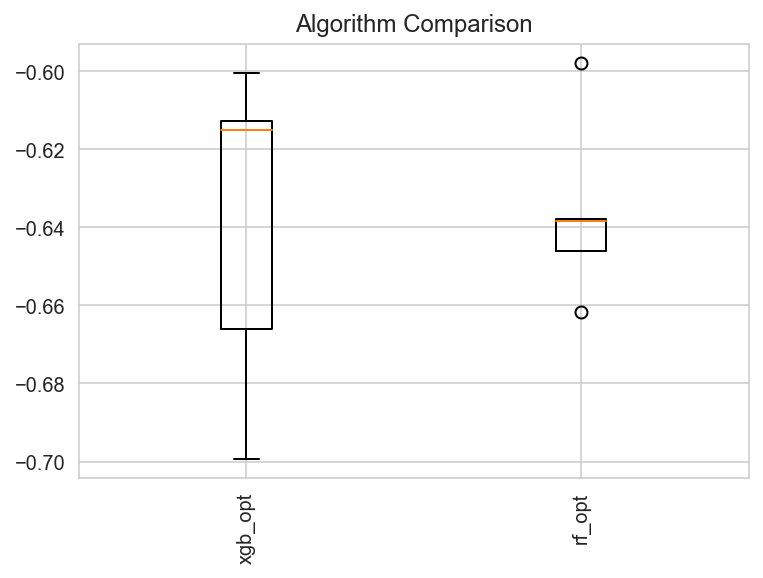

In [34]:
#cross_val_score RMSE on scaled test data
results = []
names = []
for name,model,score,params in opt_models:
    rkfold = RepeatedKFold(n_splits=5, n_repeats=1)
    cv_results = cross_val_score(model, X_test_scaled, np.ravel(y_test_scaled), cv=rkfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))    
    
print('Mean:',np.mean(cv_results.mean()))
plt.boxplot(results, labels=names)
plt.xticks(rotation=90)
plt.title('Algorithm Comparison')
plt.show()

In [35]:
#Voting Regressor on scaled train and test
opt_estimators_for_vr = [x[:2] for x in opt_models]
vr_opt=VotingRegressor(estimators=opt_estimators_for_vr) 
vr_opt.fit(X_train_scaled, np.ravel(y_train_scaled))

train_score = vr_opt.score(X_train_scaled,np.ravel(y_train_scaled))
test_score = vr_opt.score(X_test_scaled,np.ravel(y_test_scaled))
print('Voting Regressor train r2: {:.1f}%'.format(train_score*100))
print('Voting Regressor test r2: {:.1f}%'.format(test_score*100))

Voting Regressor train r2: 92.9%
Voting Regressor test r2: 72.5%


In [36]:
#why different?? rescaled data
train_score_inverse = vr_opt.score(pt_X.inverse_transform(X_train_scaled),pt_y.inverse_transform(y_train_scaled))
test_score_inverse = vr_opt.score(pt_X.inverse_transform(X_test_scaled),pt_y.inverse_transform(y_test_scaled))
print(train_score_inverse)
print(test_score_inverse)

-1.3121212274708207
-1.184225179782004


In [37]:
#extract estimator from optimised model list for train_test_r2 analysis
opt_estimators_labels = [x[0] for x in opt_models]

In [38]:
train_test_r2(opt_estimators,X_train=X_train_scaled,y_train=y_train_scaled,X_test=X_test_scaled,y_test=y_test_scaled,index=[opt_estimators_labels])

,train,test
xgb_opt,0.900099,0.723786
rf_opt,0.948819,0.701932


In [39]:
#Voting Regressor train/test r2
train_test_r2([vr_opt],X_train=X_train_scaled,y_train=y_train_scaled,X_test=X_test_scaled,y_test=y_test_scaled,index=['vr_opt'])

,train,test
vr_opt,0.929186,0.724534


In [40]:
#Voting regressor predictions on (shuffled) test data
vr_target_pred = pd.DataFrame(pt_y.inverse_transform(vr_opt.predict(X_test_scaled).reshape(-1,1)),index=X_test.index,columns=['vr_target_pred'])

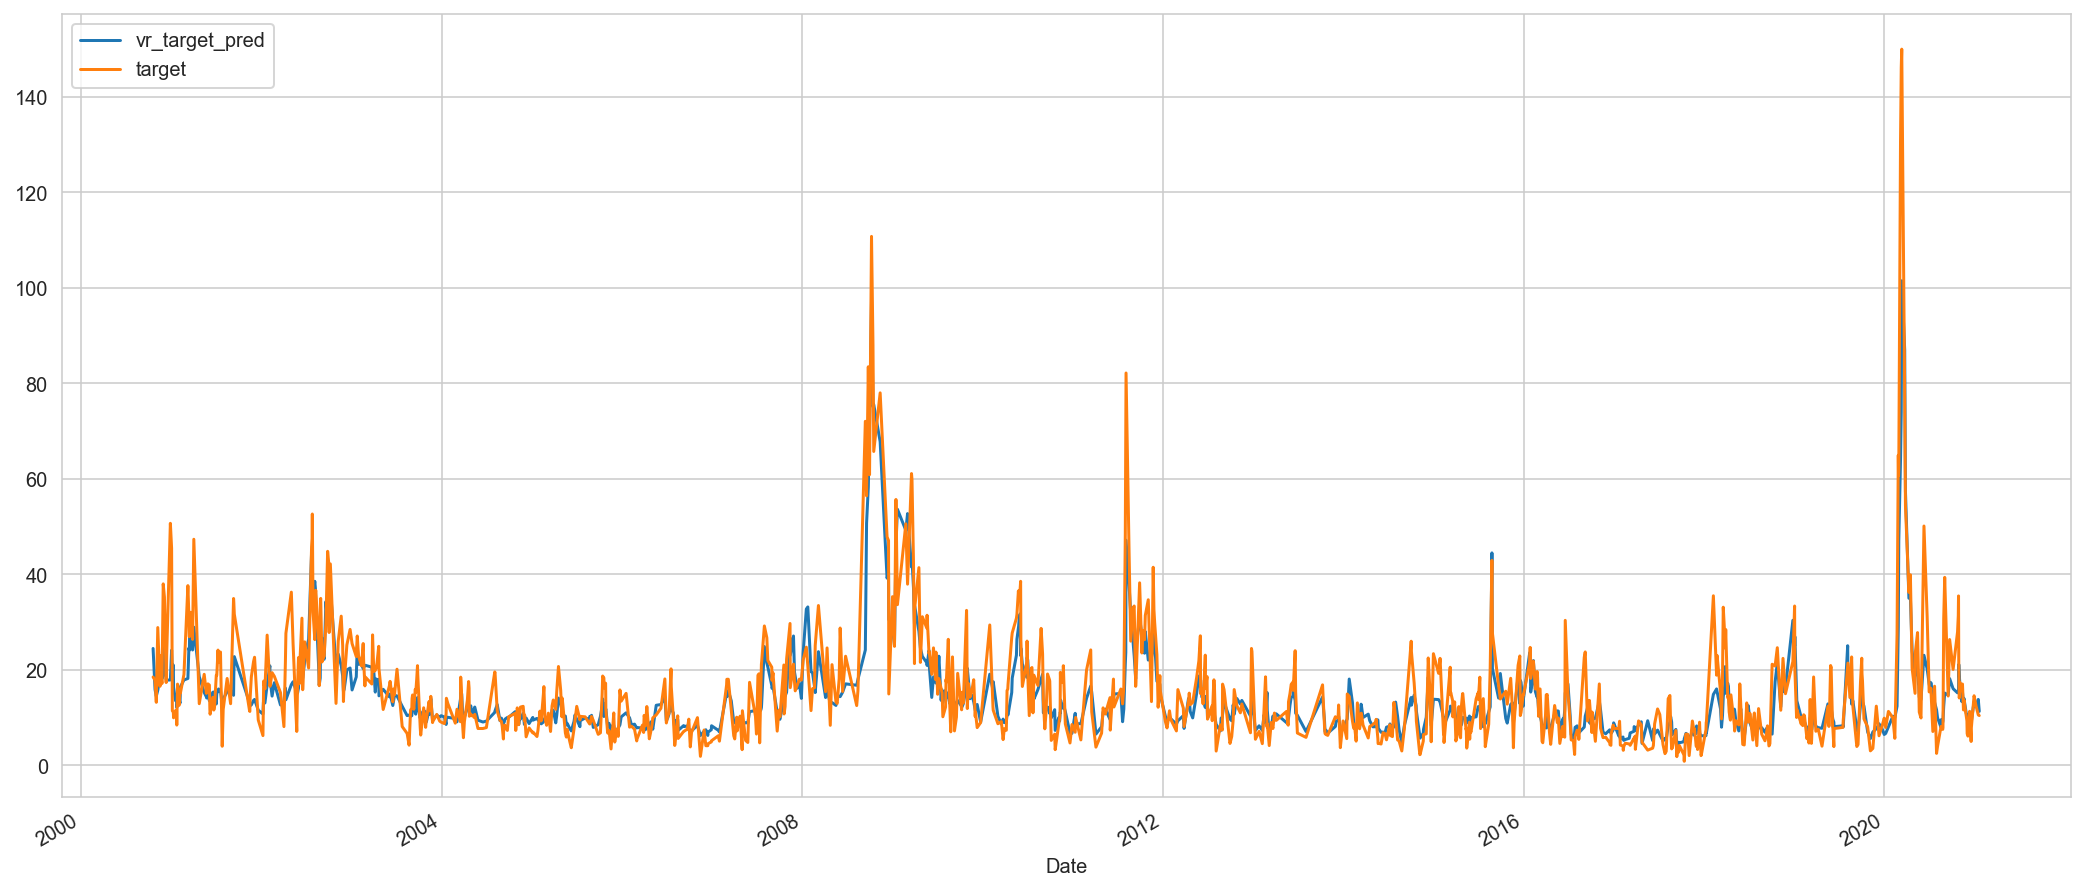

In [41]:
#test predictions with dates ordered
vr_target_pred.sort_values(by='Date').plot(figsize=(18,8))
y_test.plot()
plt.legend()

In [42]:
#Scaled last sample for live prediction
df_latest_scaled = pt_X.transform(df_with_features_latest.values.reshape(1,-1))

In [43]:
#LIVE PREDICTION
vr_latest_pred = pt_y.inverse_transform(vr_opt.predict(df_latest_scaled).reshape(-1,1))
vr_latest_pred

array([[9.83638816]])

In [44]:
df_with_features[target_col].tail(10)

Date
2021-01-12    12.475967
2021-01-13    12.414403
2021-01-14     7.599152
2021-01-15     6.652765
2021-01-19     9.301646
2021-01-20    13.642646
2021-01-21    13.749761
2021-01-22    13.552801
2021-01-25    10.556736
2021-01-26    10.418399
Name: ^GSPC 5d vol, dtype: float64

In [45]:
#Create dataframe for Classification analysis
df_class = pd.concat([
                    df_clean['^VIX'][y_test.index],
                    df_clean[target_col][y_test.index],
                    y_test,
                    vr_target_pred,
                    df_clean['target_binary'][y_test.index]],
                    axis=1).sort_values(by='Date')

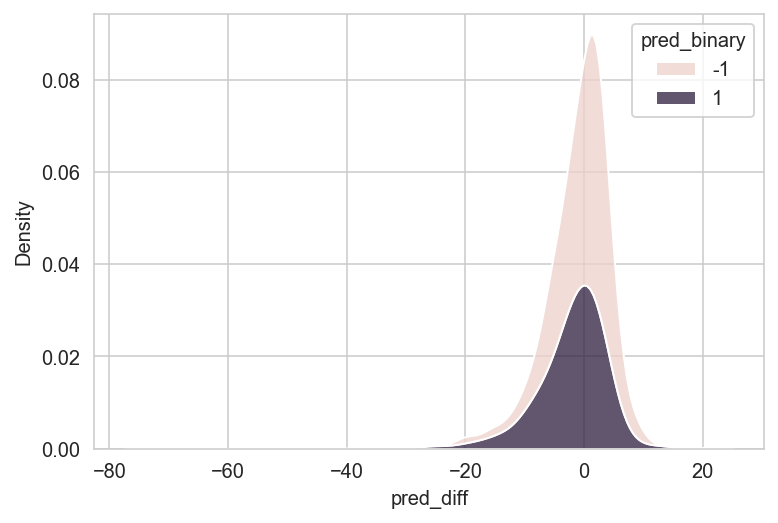

In [46]:
#Inspecting distribution of predictions vs. actual realised volatility
df_class['pred_binary'] = np.where(df_class['vr_target_pred']>df_class[target_col],1,-1)
df_class['pred_diff'] = df_class['vr_target_pred'] - df_class['target']
df_class['pred_diff_from_current'] = df_class['vr_target_pred'] - df_class[target_col]
df_class['actual_diff_from_current'] = df_class['target'] - df_class[target_col]
sns.kdeplot(data=df_class,x='pred_diff',hue='pred_binary',multiple='stack')

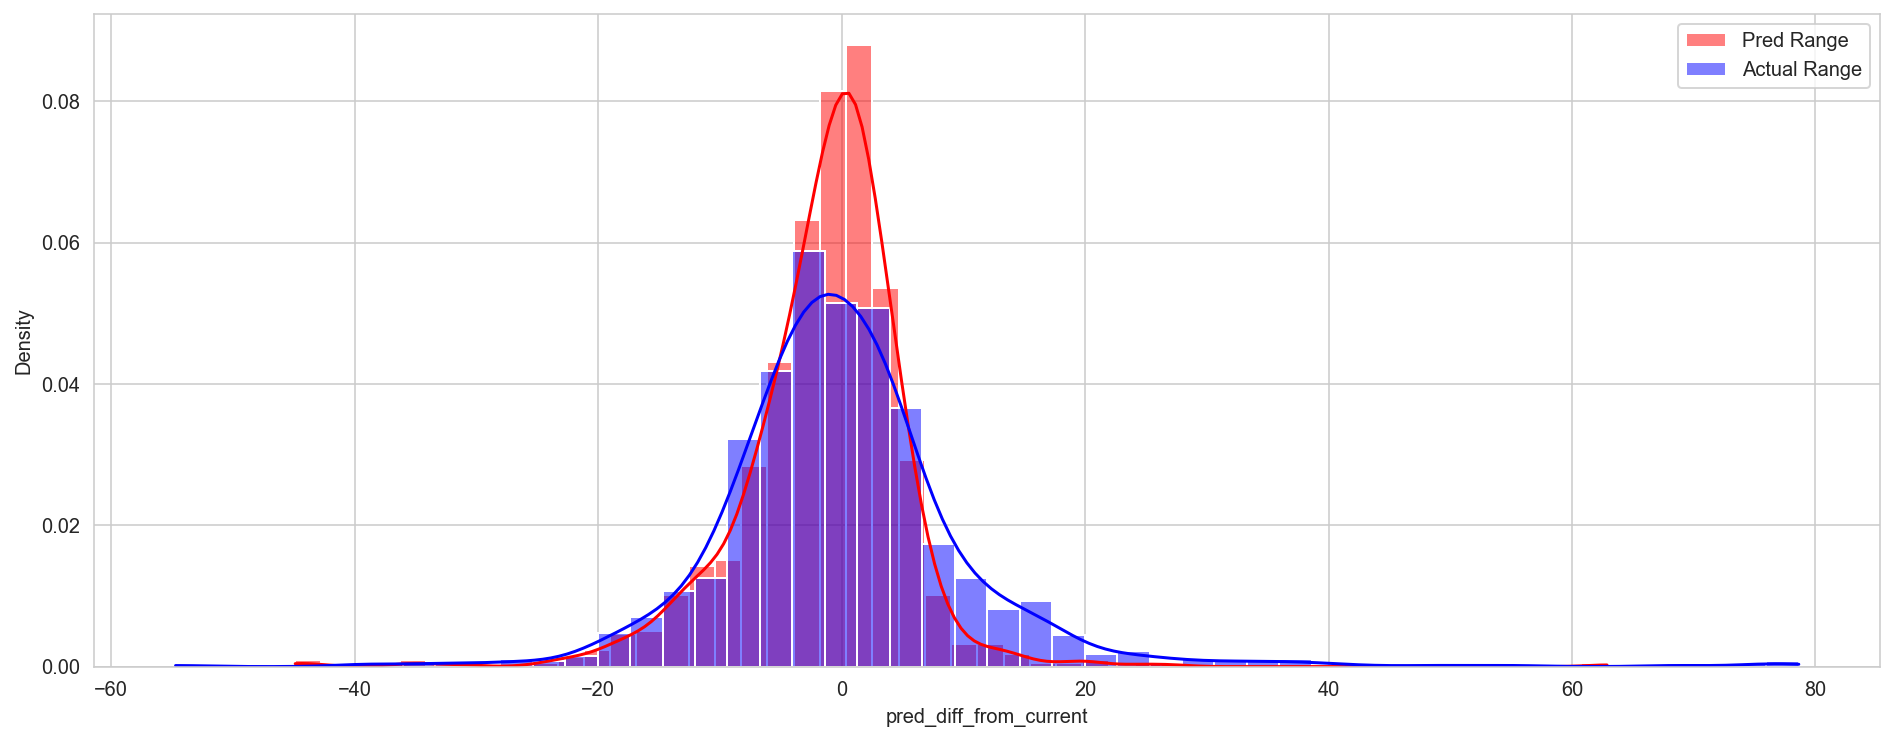

In [47]:
fig,ax=plt.subplots(figsize=(16,6))
sns.histplot(data=df_class,x='pred_diff_from_current',label='Pred Range',kde=True,color='r',bins=50,stat='density',fill=True,alpha=0.5)
sns.histplot(data=df_class,x='actual_diff_from_current',label='Actual Range',kde=True,color='b',bins=50,alpha=0.5,stat='density')
plt.legend()

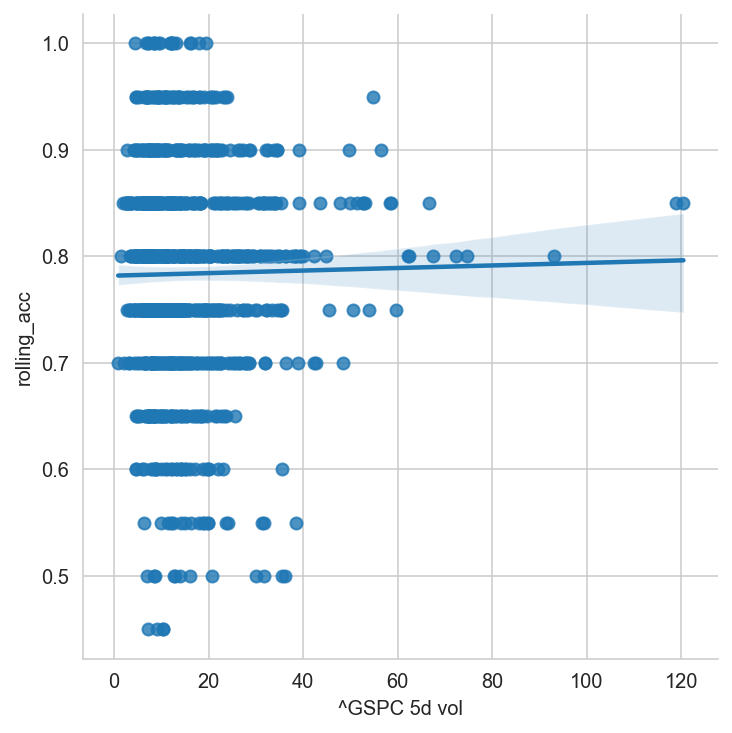

In [48]:
#Accuracy vs. realised voltility regime
df_class['accuracy'] = np.where(df_class['target_binary'] == df_class['pred_binary'],1,0)
df_class['rolling_acc'] = df_class['accuracy'].rolling(20).mean()
sns.lmplot(data=df_class,x=target_col,y='rolling_acc')

In [49]:
print(df_class['target_binary'].value_counts())
print(df_class['pred_binary'].value_counts())

-1    538
 1    475
Name: target_binary, dtype: int64
-1    561
 1    452
Name: pred_binary, dtype: int64


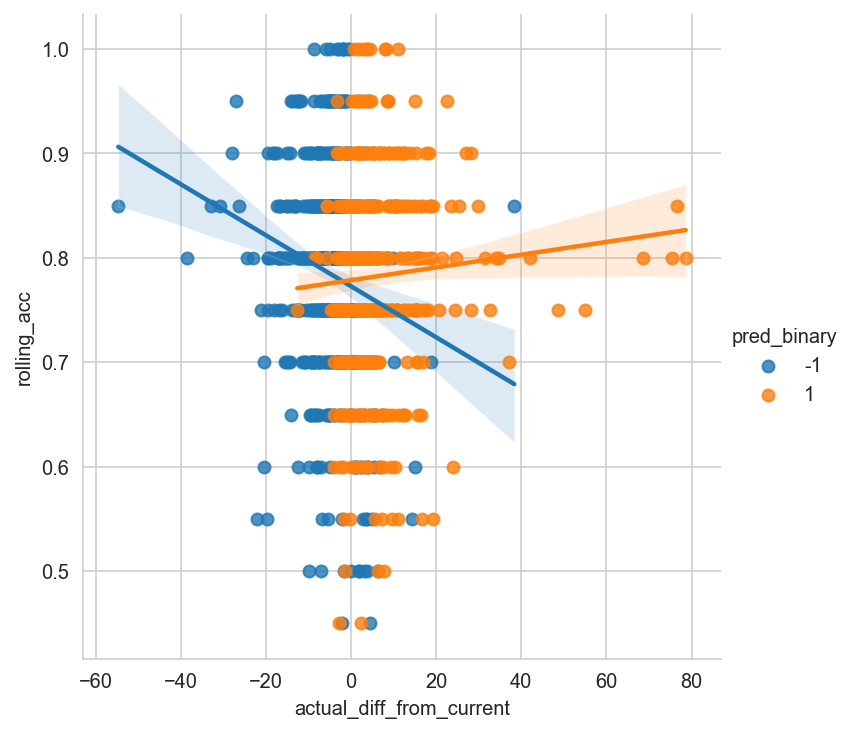

In [50]:
sns.lmplot(data=df_class,x='actual_diff_from_current',y='rolling_acc',hue='pred_binary')

In [51]:
print(accuracy_score(df_class['target_binary'],df_class['pred_binary']))
df_class['accuracy'].mean()

0.7857847976307996


0.7857847976307996

In [52]:
#Accuracy per weekday
df_class['accuracy'].groupby(df_class.index.weekday).mean()

Date
0    0.725888
1    0.768868
2    0.769585
3    0.844920
4    0.825000
Name: accuracy, dtype: float64

In [53]:
#predition based position
df_class['pos_vs_target'] = np.where(df_class['vr_target_pred'] > df_class[target_col],1,-1)
df_class['pos_vs_vix'] = np.where(df_class['vr_target_pred'] > df_class['^VIX'],1,-1)

In [54]:
#Potential strategies
df_class['pred_pnl'] = (df_class['target'] - df_class[target_col])*df_class['pos_vs_target']
df_class['pred_pnl_vix'] = (df_class['target'] - df_class['^VIX'])*df_class['pos_vs_vix']

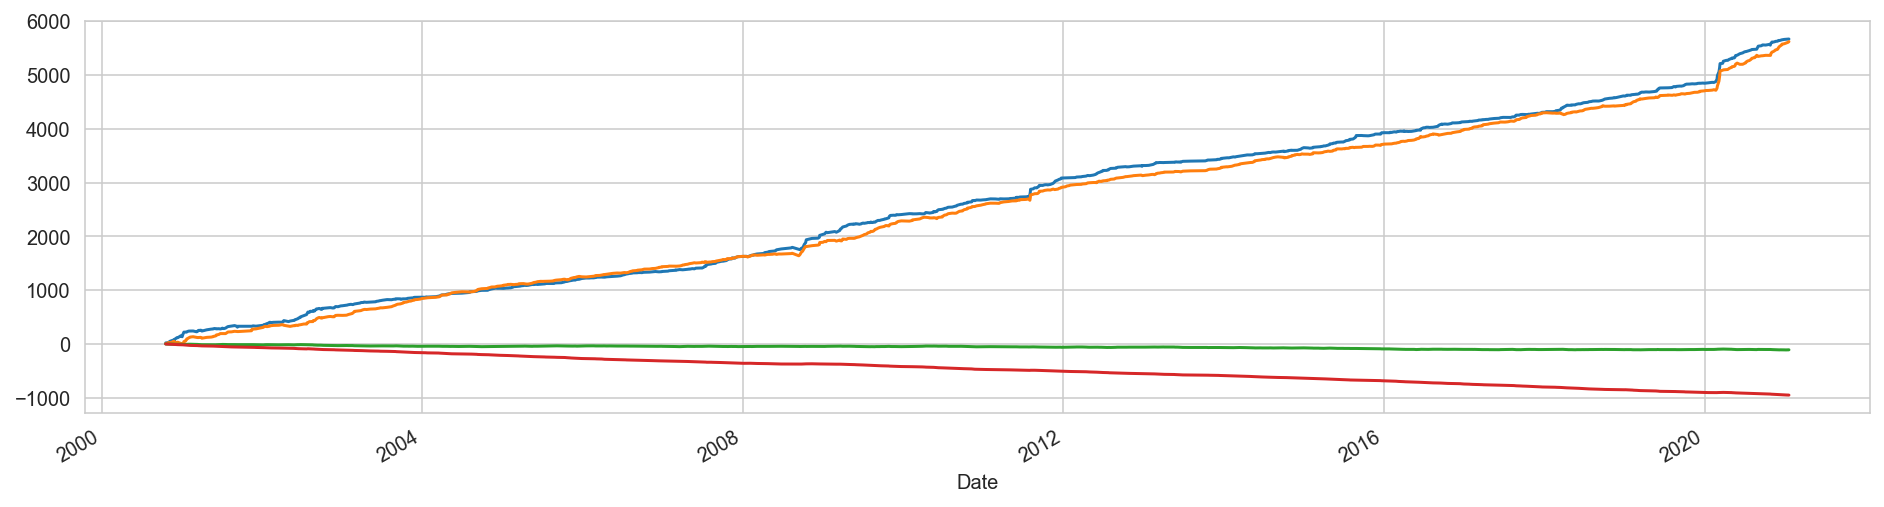

In [55]:
df_class['pred_pnl'].cumsum().plot(figsize=(16,4))
df_class['pred_pnl_vix'].cumsum().plot()
df_class['pos_vs_target'].cumsum().plot()
df_class['pos_vs_vix'].cumsum().plot()

In [56]:
confusion_matrix(df_class['target_binary'],df_class['pred_binary'])

array([[441,  97],
       [120, 355]])

In [57]:
f1_score(df_class['target_binary'],df_class['pred_binary'])

0.7659115426105717

In [58]:
mean_absolute_error(df_class['vr_target_pred'], df_class['target'])

4.23389235885592

In [59]:
abs(df_class['pred_diff']).mean()

4.23389235885592

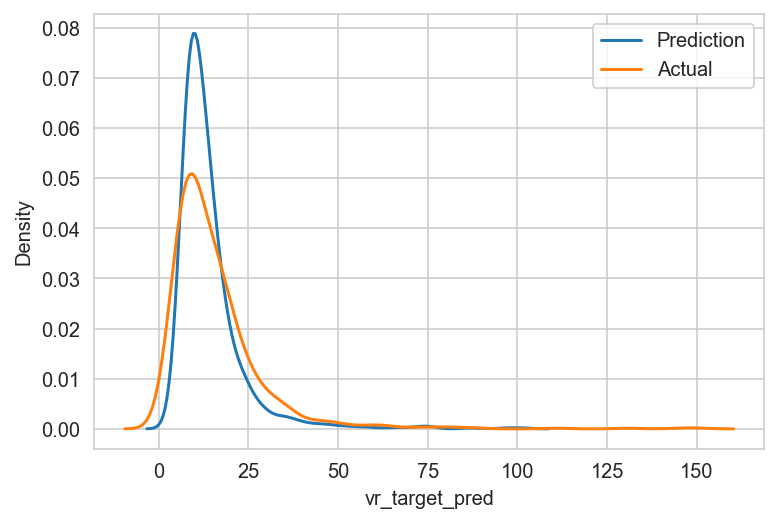

In [60]:
sns.kdeplot(data=vr_target_pred,x='vr_target_pred',label='Prediction')
sns.kdeplot(data=y_test,label='Actual')
plt.legend()

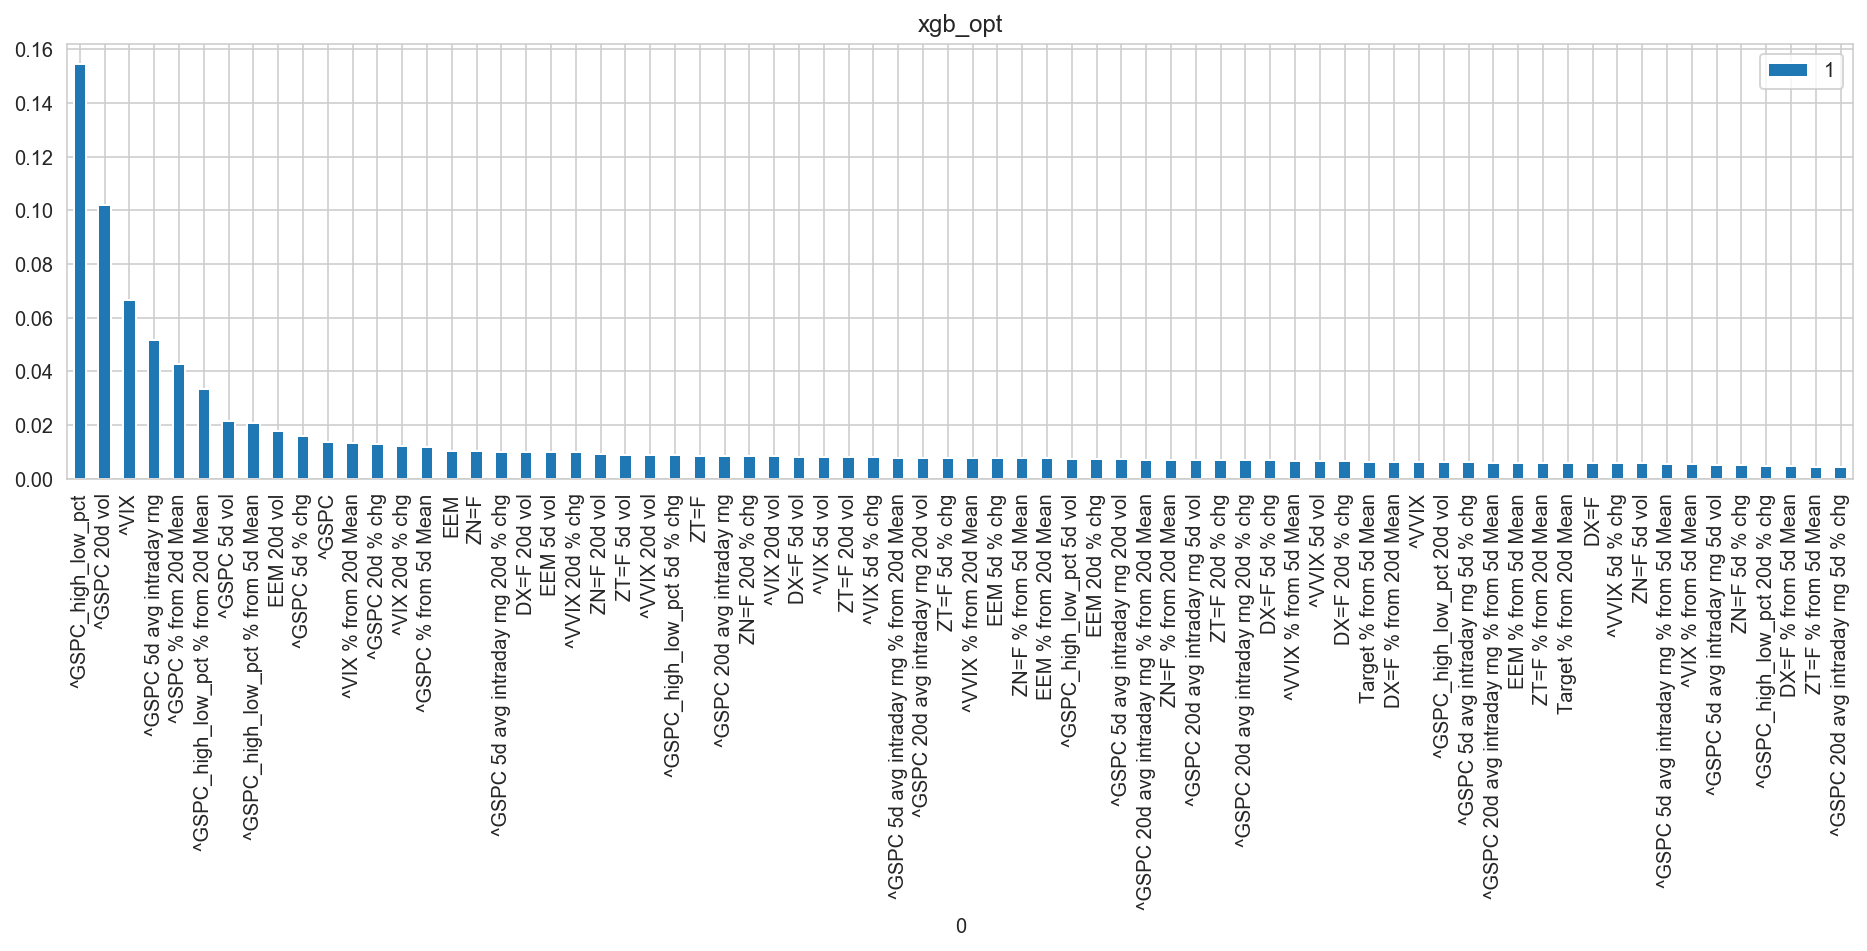

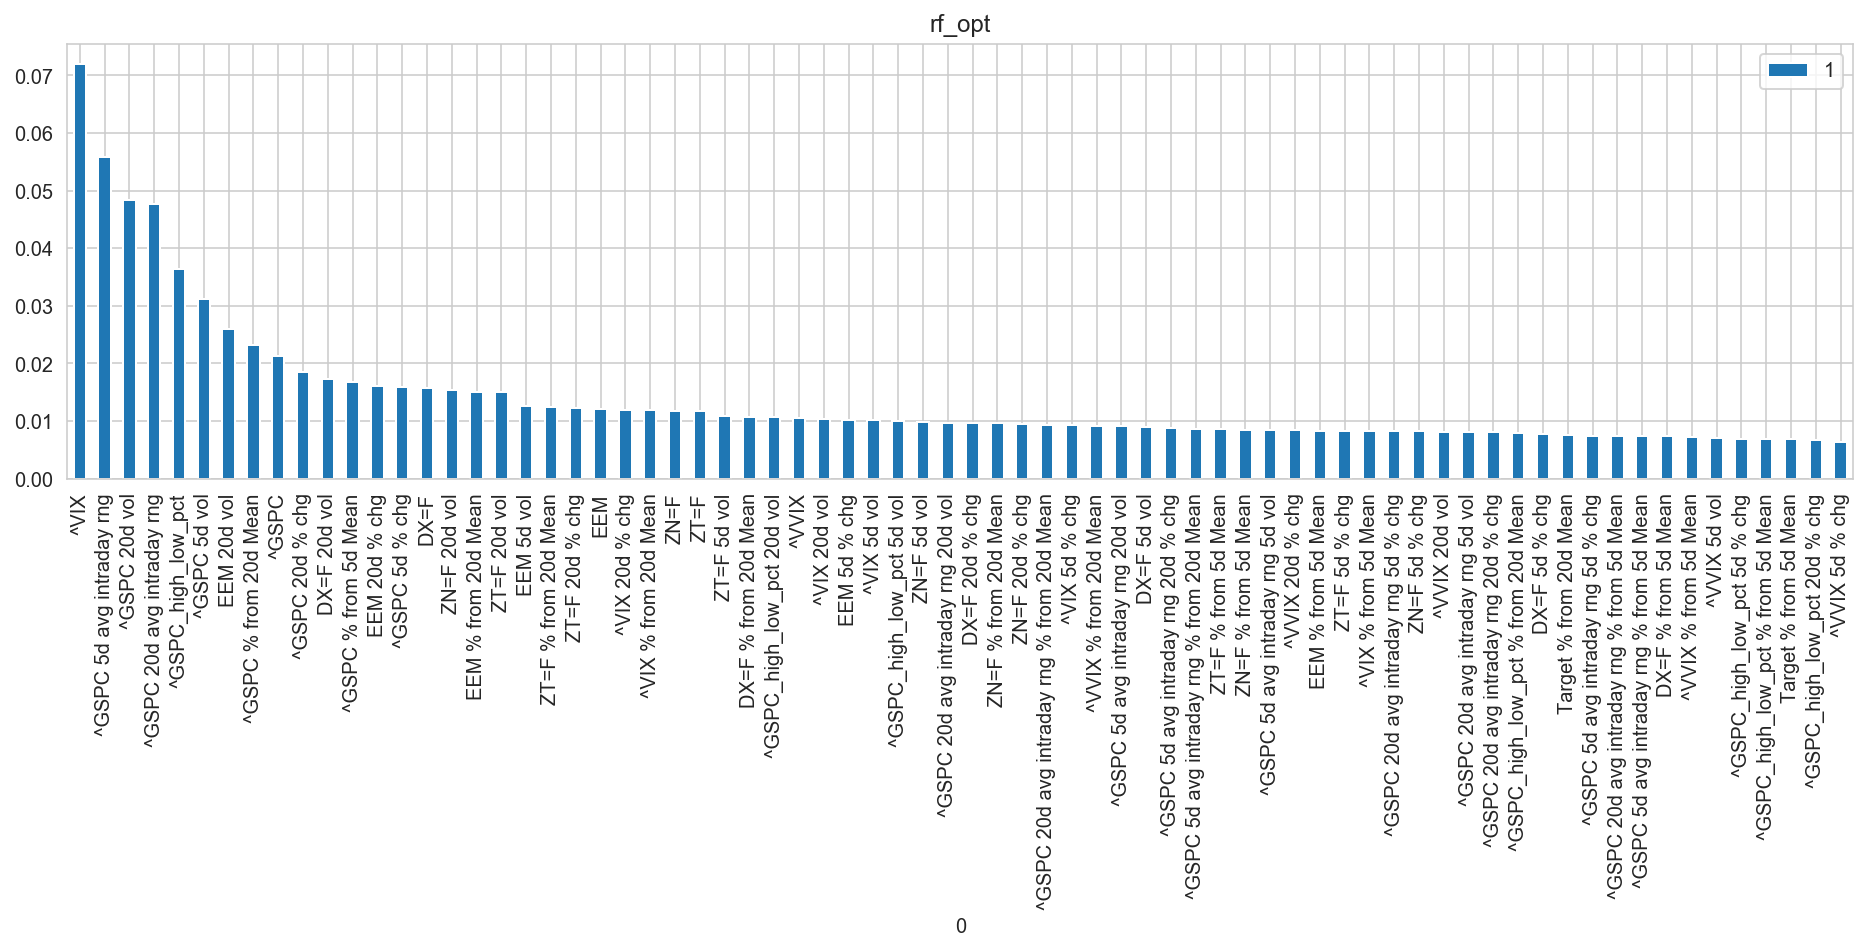

In [61]:
#FEATURE IMPORTANCES
for model_name, model,_,_ in opt_models:
    importance = []
    for feature in zip(df_clean_features.columns, model.feature_importances_):
        importance.append(feature)

    feat_imp = pd.DataFrame(data=importance).set_index(0).sort_values(by=1,ascending=False)
    feat_imp.plot(figsize=(16,4),kind='bar',title=model_name)